This code calculates the change of profile of Fields of Research (FoR) embeddings using semantic change approaches.

* Author: Barbara
* Date: March 2020
* Based on code written by Khalid and Donna.





# Initialization


In [1]:
from google.colab import drive
drive.mount('/gdrive', force_remount = True) 
%ls '/gdrive/My Drive/SpringerNature-Google-Turing/data'

Mounted at /gdrive
 Five-year-sg-d100-w2-ns5/            Mean-title-centroids-3yrs-v02/
 Five-year-sg-d12-w4-ns1/             Three-year-sg-d100-w2-ns5/
 Five-year-sg-d12-w4-ns5/             Three-year-sg-d12-w2-ns1/
 for_co-occurrence_counts_11-13.csv   Three-year-sg-d12-w2-ns2/
 for_co-occurrence_counts_14-16.csv   Three-year-sg-d12-w2-ns3/
 for_co-occurrence_counts_17-19.csv   Three-year-sg-d12-w2-ns5/
 for_levels.csv                       Three-year-sg-d12-w4-ns1/
'FoR mapping - Extract 1.csv'         Three-year-sg-d12-w4-ns2/
'FoR mapping - Extract 1.gsheet'      Three-year-sg-d12-w4-ns3/
 for_nsize_density.csv                Three-year-sg-d12-w4-ns5/
 for_nsize_negcorr.csv                Three-year-sg-journals/
 FoR-Ontology.csv                     wv_11_13.txt
 for_regression_coef.csv              wv_14_16.txt
 FoR_W2V_v01.html                     wv_17_19.txt
 Mean-title-centroids-3yrs/


In [2]:
import os
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict, OrderedDict
import numpy as np
import pandas as pd
from statistics import median, mean
from os import listdir
from os.path import isfile, join
import re
import plotly.express as px
import statistics
import matplotlib.pyplot as plt
import csv

## Parameters

In [3]:
embedding_type = "cooccurrence" # options are "cooccurrence" for co-occurrence-based FoR embeddings and "aggregated" for aggregated title embeddings
if embedding_type == "aggregated":
  year_intervals = 3
  num_dimensions = 512
  f_code = "f2"  # level of FoR codes for which the embeddings are created, can be f1 or f2
elif embedding_type == "cooccurrence":
  year_intervals = 3 
  num_dimensions = 12 # number of dimensions of embeddings
  window_size = 2 
  negative_sampling = 1
  f_code = "f2" # level of FoR codes for which the embeddings are created; it is f2
elif embedding_type == "journal":
  year_intervals = 3
  num_dimensions = 100
  f_code = "f2"

reference_step = "last" # time step used as reference point for comparison; for example, if this is "first", we compare embeddings for subsequent time steps with the embeddings for the first time step

In [4]:
last_year = 2019
if year_intervals == 3:
  first_year = 1990 
elif year_intervals == 5:
  first_year = 1950

In [5]:
BASE_DIR = '/gdrive/My Drive/SpringerNature-Google-Turing'
DATA_DIR = BASE_DIR + '/data'
if embedding_type == "cooccurrence":
  if year_intervals == 3:
    years_words = "Three"
  elif year_intervals == 5:
    years_words = "Five"
  DATA_DIR_yrs = DATA_DIR + '/' + years_words + '-year-sg-d' + str(num_dimensions) + '-w' + str(window_size) + '-ns' + str(negative_sampling)
elif embedding_type == "aggregated":
  DATA_DIR_yrs = os.path.join(DATA_DIR, 'Mean-title-centroids-3yrs-v02')
elif embedding_type == "journal":
  DATA_DIR_yrs = os.path.join(DATA_DIR, "Three-year-sg-journals")

# Functions

## Function for loading embeddings

In [6]:
# Function that loads the embeddings from the embedding file (From Khalid's and Donna's script)
def load_embeddings(embedding_file):

  embeddings = {}
  with open(os.path.join(DATA_DIR_yrs, embedding_file)) as file_reader:
    lines = file_reader.readlines()
    
    # skip the first line
    lines = lines[1:]

    # parse embedding lines
    for line in lines:
      parts = line.split(' ')
      embedding = [float(value) for value in parts[-num_dimensions:]]
      field = ' '.join(parts[:-num_dimensions])
      embeddings[field] = embedding

  return embeddings

## Function for alignment of the FoR embeddings using Procustes alignment.
Code adapted from https://gist.github.com/quadrismegistus/09a93e219a6ffc4f216fb85235535faf.


In [7]:
def diff(first, second):
        second = set(second)
        return [item for item in first if item not in second]

def intersection_align(m1,m2):
  """
  Intersect two embedding models, m1 and m2, intended as two dictionaries which map a Field of Research code to the vector of its embedding values.
  Only the shared vocabulary between them is kept.
  Indices are re-organized from 0..N in alphabetical order. 
  """

  # Get the vocab for each model
  vocab_m1 = set(m1.keys())
  vocab_m2 = set(m2.keys())

  # Find the common vocabulary
  common_vocab = vocab_m1&vocab_m2
  common_vocab = list(sorted(common_vocab))
  #print("Common_vocab", str(common_vocab))
  #print(type(common_vocab))
  #print(str(list(vocab_m1)))
  #print("vocab_m1 - common_vocab", str(diff(list(vocab_m1),common_vocab)))
  #print("vocab_m2 - common_vocab", str(diff(list(vocab_m2),common_vocab)))

  new_m1 = dict()
  new_m2 = dict()
    
	# If no alignment necessary because vocab is identical...
  if not diff(list(vocab_m1),common_vocab) and not diff(list(vocab_m2),common_vocab):
    new_m1 = m1
    new_m2 = m2
  else:
  	# Otherwise sort by frequency (summed for both)


    # Each model is replaced with a new version, only defined on the intersection of the vocabularies
    for field in common_vocab:
      new_m1[field] = m1[field]
      new_m2[field] = m2[field]

  return (common_vocab, new_m1,new_m2)

In [8]:
def smart_procrustes_align(base_embed, other_embed, num_dimensions_par):

  """Procrustes align two gensim word2vec models (to allow for comparison between same word across models).
  First, intersect the vocabularies (see `intersection_align` documentation).
  Then do the alignment on the other_embed model.
  Replace the other_embed model's numpy matrices with the aligned version.
  Return other_embed.
  """

  # make sure vocabularies are aligned
  common_vocab, in_base_embed, in_other_embed = intersection_align(base_embed, other_embed)

	# get the embedding matrices
  base_array = np.empty((0, num_dimensions_par))
  other_array = np.empty((0, num_dimensions_par))
  for field in common_vocab:
    base_array = np.append(base_array, [base_embed[field]], axis=0)
    #print("Base array", str(base_array))
    other_array = np.append(other_array, [other_embed[field]], axis=0)
    #print("Other array", str(other_array))

#  print("Base array", str(base_array))
#  print("Other array", str(other_array))
  # just a matrix dot product with numpy
  m = other_array.T.dot(base_array) 
  # SVD method from numpy
  u, _, v = np.linalg.svd(m)
  # another matrix operation
  ortho = u.dot(v) 
  # Replace original array with modified one
  # i.e. multiplying the embedding matrix by "ortho"
  other_array = (other_array).dot(ortho)
  return (base_array, other_array)



Function that returns the top x nearest neighbours of an embedding for a year

In [9]:
def nearest_neighbours(number_of_neighbours, year, all_embeddings_dict, target_field):
  cosines_field = dict() # maps a field to the cosine between its embedding and the embedding of target_field
  #print("Considering target field " + target_field)
  #print(str(all_embeddings_dict[year][target_field]))
  for field in all_embeddings_dict[year]:
    if field != target_field:
      #print("Comparing with field " + field)
      #print(str(all_embeddings_dict[year][field]))
      cosines_field[field] = cosine_similarity([all_embeddings_dict[year][field]], [all_embeddings_dict[year][target_field]])
      cosines_field[field] = [item for sublist in cosines_field[field] for item in sublist]
      #print("Cosine:" + str(cosines_field[field]))
  #print("Cosines:" + str(cosines_field))
  cosines_field_sorted = OrderedDict(sorted(cosines_field.items(), key=lambda x: x[1], reverse=True))
  #print("Cosines sorted:" + str(cosines_field_sorted))
  fields = list(cosines_field_sorted.keys())
  #print(str(fields))
  top_neighbours = fields[:number_of_neighbours]
  #print("Top " + str(number_of_neighbours) + " neighbours for " + target_field + " in " + str(year) + ": " + str(top_neighbours))
  return top_neighbours


# Read data

Read embedding files


In [10]:
embeddingfiles = [f for f in listdir(DATA_DIR_yrs) if isfile(join(DATA_DIR_yrs, f))]
print("There are", str(len(embeddingfiles)), "embedding files")

There are 10 embedding files


In [11]:
year2embeddings = dict() # dictionary that maps a year_start to the embedding file for that (year, year + year_intervals) period
for f in embeddingfiles:
  m = re.match(r'wv_(\d\d)_(\d\d)', f)
  year_start = m.group(1)
  #year_end = m.group(2)
  #print("file", f, "Year start:", str(year_start), "Year end:", str(year_end))
  year2embeddings[int(year_start)] = f
print(str(year2embeddings))

{17: 'wv_17_19.txt', 14: 'wv_14_16.txt', 11: 'wv_11_13.txt', 8: 'wv_08_10.txt', 5: 'wv_05_07.txt', 2: 'wv_02_04.txt', 99: 'wv_99_01.txt', 96: 'wv_96_98.txt', 93: 'wv_93_95.txt', 90: 'wv_90_92.txt'}


# Analysis of FoR profiles over time


## Load embeddings


In [12]:
all_embeddings = dict() # Dictionary that maps a year_start with the embeddings for the (year, year + year_intervals-1) period; 
# the embeddings are dictionaries that map a FoR to the list of its embedding's numeric values
#print(str(first_year), "!")
#print(str(last_year), "!")
for y in range(first_year, last_year, year_intervals):
  #print("Year", str(y))
  y0 = int(str(y)[2:4])
  #print("y0=", str(y0))
  embeddings = load_embeddings(year2embeddings[y0])
  all_embeddings[y] = embeddings
print(str(all_embeddings[1990]))  

{'Clinical Sciences': [0.1974715, 0.22966398, 0.1804166, 0.0774011, 0.01708955, 0.33056173, 0.41062304, 0.09632339, -0.07309412, 0.30680743, -0.55706567, -0.16921696], 'Biochemistry and Cell Biology': [-0.32941237, -0.1320581, 0.60355103, 0.056105047, -0.044939097, -0.10726956, -0.069902115, -0.06425217, 0.040263485, -0.6903286, -0.43462393, -0.3365515], 'Physical Chemistry (incl. Structural)': [-0.42209974, 0.1947426, -0.18296921, 0.26524282, 0.2524196, -0.89814353, -0.046947513, 0.46837142, -0.96513367, -0.3206615, 0.8224363, 1.2876769], 'Neurosciences': [0.11649645, 0.20873934, 0.07165145, 0.0072083725, 0.074295655, 0.2893901, 0.114981934, 0.05268254, 0.2129018, 0.23115426, -0.2722415, -0.265162], 'Genetics': [-0.6879673, -0.034159124, 0.4442217, 0.22983259, 0.08623586, 0.2306291, -0.20787501, 0.5409785, 0.28077346, -0.9510211, -0.97321594, -0.4569948], 'Materials Engineering': [-0.16931061, -0.11296664, -0.19459759, 0.029309478, 0.22874348, -0.7551398, -0.04588718, 0.3988826, -0.77

### Validate the loaded embeddings

In [13]:
print("Parsed embedding count: {}.".format(len(all_embeddings.items())))
valid = True
for y in range(first_year, last_year, year_intervals):
  print("Validating embedddings for year", str(y))#, str(all_embeddings[y]))
  embedding_dict = all_embeddings[y]
  for field in embedding_dict: 
    #print("field", field, "embedding", str(embedding_dict[field]))
    if len(embedding_dict[field]) != num_dimensions:
      #print("Embedding shorter than expected!", str(len(embedding_dict[field])))
      valid = False
      break

if valid:
  print("All embeddings have size of", str(num_dimensions))

Parsed embedding count: 10.
Validating embedddings for year 1990
Validating embedddings for year 1993
Validating embedddings for year 1996
Validating embedddings for year 1999
Validating embedddings for year 2002
Validating embedddings for year 2005
Validating embedddings for year 2008
Validating embedddings for year 2011
Validating embedddings for year 2014
Validating embedddings for year 2017
All embeddings have size of 12


### Intersection of FoR in a few examples 

In [14]:
if year_intervals == 5:
  (common_vocab_1950_1955,common_vocab_matrix_1950,common_vocab_matrix_1955) = intersection_align(all_embeddings[1950],all_embeddings[1955])
  print(str(common_vocab_1950_1955))
  print(str(common_vocab_matrix_1950))
  print(str(common_vocab_matrix_1955))
elif year_intervals == 3:
  (common_vocab_1990_1993,common_vocab_matrix_1990,common_vocab_matrix_1993) = intersection_align(all_embeddings[1990],all_embeddings[1993])
  print(str(common_vocab_1990_1993))
  print(str(common_vocab_matrix_1990))
  print(str(common_vocab_matrix_1993))

['Accounting, Auditing and Accountability', 'Aerospace Engineering', 'Agricultural Biotechnology', 'Agriculture, Land and Farm Management', 'Analytical Chemistry', 'Animal Production', 'Anthropology', 'Applied Economics', 'Applied Ethics', 'Applied Mathematics', 'Archaeology', 'Architecture', 'Artificial Intelligence and Image Processing', 'Astronomical and Space Sciences', 'Atmospheric Sciences', 'Atomic, Molecular, Nuclear, Particle and Plasma Physics', 'Automotive Engineering', 'Banking, Finance and Investment', 'Biochemistry and Cell Biology', 'Biomedical Engineering', 'Building', 'Business and Management', 'Cardiorespiratory Medicine and Haematology', 'Chemical Engineering', 'Civil Engineering', 'Classical Physics', 'Clinical Sciences', 'Cognitive Sciences', 'Communication and Media Studies', 'Communications Technologies', 'Complementary and Alternative Medicine', 'Computation Theory and Mathematics', 'Computer Hardware', 'Computer Software', 'Condensed Matter Physics', 'Criminolo

### Alignment of embeddings in a few examples

In [15]:
if year_intervals == 5:
  new_1950, new_1955 = smart_procrustes_align(all_embeddings[1950], all_embeddings[1955], num_dimensions)
  #print("new 1950", str(new_1950))
  #print("new 1955", str(new_1955))
  print(common_vocab_1950_1955[0])
  print("new 1950 for ", common_vocab_1950_1955[0], str(new_1950[0]))
  print("new 1955 for ", common_vocab_1950_1955[0], str(new_1955[0]))
elif year_intervals == 3:
  new_1990, new_1993 = smart_procrustes_align(all_embeddings[1990], all_embeddings[1993], num_dimensions)
  print(common_vocab_1990_1993[0])
  print("new 1990 for ", common_vocab_1990_1993[0], str(new_1990[0]))
  print("new 1993 for ", common_vocab_1990_1993[0], str(new_1993[0]))

Accounting, Auditing and Accountability
new 1990 for  Accounting, Auditing and Accountability [ 0.12160762  0.04028399 -0.2160426   0.33352527  0.7157405   0.40093437
 -0.23288241 -0.26488763 -0.44216353  0.01768613 -0.20632254  0.110751  ]
new 1993 for  Accounting, Auditing and Accountability [ 0.14719498  0.05567174 -0.19770493  0.45239504  0.84866567  0.50851296
 -0.26413932 -0.39546719 -0.44598537  0.09193541 -0.23235208  0.10022015]


# Profile change of FoR

## Cosine similarity measure

### FoR that have changed the most between two selected years

In [16]:
if year_intervals == 5:
  print("FoR that have changed the most between 1950 and 1955: ")
  for field_index in range(len(common_vocab_1950_1955)):
    cosine = cosine_similarity([new_1950[field_index]], [new_1955[field_index]])
    if cosine < 0.5:
      print(str(field_index), str(common_vocab_1950_1955[field_index]))
elif year_intervals == 3:
  print("FoR that have changed the most between 1990 and 1993: ")
  for field_index in range(len(common_vocab_1990_1993)):
    cosine = cosine_similarity([new_1990[field_index]], [new_1993[field_index]])
    if cosine < 0.5:
      print(str(field_index), str(common_vocab_1990_1993[field_index]), str(cosine))

FoR that have changed the most between 1990 and 1993: 
3 Agriculture, Land and Farm Management [[0.45561649]]
56 Food Sciences [[0.40208933]]
85 Medical Biochemistry and Metabolomics [[0.48885192]]


### FoR that have changed the most between first and last year.

These are defined by setting a threshold of 0.5 to the cosine similarity score.



In [17]:
#Initialize the data frame:
changed_for_first_last = pd.DataFrame(columns=['FoR', 'CosSimScore'])

if year_intervals == 5:
  first_y_emb = 1950
  last_y_emb = 2015
elif year_intervals == 3:
  first_y_emb = 1990
  last_y_emb = 2017

(common_vocab_firstlast,common_vocab_matrix_first,common_vocab_matrix_last) = intersection_align(all_embeddings[first_y_emb],all_embeddings[last_y_emb])
new_first_y_emb, new_last_y_emb = smart_procrustes_align(all_embeddings[first_y_emb], all_embeddings[last_y_emb], num_dimensions)

for field_index in range(len(common_vocab_firstlast)):
  cosine = cosine_similarity([new_first_y_emb[field_index]], [new_last_y_emb[field_index]])
  if cosine < 0.5:
  # Append rows to data frame:
    changed_for_first_last = changed_for_first_last.append({'FoR': common_vocab_firstlast[field_index], 'CosSimScore': round(float(cosine[0]), 3)}, ignore_index=True)

changed_for_first_last

,FoR,CosSimScore
0,Aerospace Engineering,0.498
1,"Agriculture, Land and Farm Management",0.346
2,Architecture,0.286
3,Astronomical and Space Sciences,0.417
4,Automotive Engineering,0.021
5,Biomedical Engineering,0.346
6,Building,0.016
7,Cardiorespiratory Medicine and Haematology,0.198
8,Communication and Media Studies,-0.067
9,Complementary and Alternative Medicine,0.194


In [18]:
changed_for_first_last = changed_for_first_last.sort_values(by=['CosSimScore'], ascending=False)

In [19]:
changed_for_first_last

,FoR,CosSimScore
0,Aerospace Engineering,0.498
13,Immunology,0.479
20,Nutrition and Dietetics,0.431
3,Astronomical and Space Sciences,0.417
19,Neurosciences,0.372
1,"Agriculture, Land and Farm Management",0.346
5,Biomedical Engineering,0.346
14,Journalism and Professional Writing,0.336
2,Architecture,0.286
23,Other Medical and Health Sciences,0.282


Print to output file

In [30]:
DIR_OUT = os.path.join(BASE_DIR, 'analysis')
if not os.path.exists(DIR_OUT):
    os.makedirs(DIR_OUT)
DIR_OUT2 = os.path.join(DIR_OUT,'profile change')
if not os.path.exists(DIR_OUT2):
    os.makedirs(DIR_OUT2)
if embedding_type == "cooccurrence":
  out_file_name = 'FoR-profiles_changed_between_'+str(first_y_emb) + '-' + str(last_y_emb) + '_Year_intervals-' + str(year_intervals) + '_num_dimensions-' + str(num_dimensions) + '_reference_step-' + str(reference_step) + '_window_size-' + str(window_size) + '_negative_sampling-' + str(negative_sampling) + '.csv'
elif embedding_type in ["aggregated", "journal"]:
  out_file_name = 'FoR-profiles_changed_between_'+str(first_y_emb) + '-' + str(last_y_emb) + '_Year_intervals-' + str(year_intervals) + '_num_dimensions-' + str(num_dimensions) + '_reference_step-' + str(reference_step) + '.csv'

out_file = open(os.path.join(DIR_OUT2, out_file_name), 'w')
changed_for_first_last.to_csv(out_file,index = False)
out_file.close()

### Time series analysis for FoR profile change

Compare the embedding space in the year chosen as reference point (first or last) and the embedding spaces in subsequent years, and calculate cosine similarity between the Fields of Research embeddings in the two spaces



In [20]:
keys = all_embeddings[1990].keys()
field = list(keys)[0]
nearest_neighbours(3,1990, all_embeddings, field)

['Paediatrics and Reproductive Medicine',
 'Public Health and Health Services',
 'Neurosciences']

In [21]:
cosine_ref_year_next_years = dict() # dictionary of lists: if reference_step is "first", first list corresponds 
# to reference year considered (first_year+year_intervals), 
#second list to first_year+2*year_intervals, etc.; 
# maps a field to the list of cosines between the embeddings for this field in reference year 
# and the embeddings for the same field in each of the other years
common_fields = list() # list of fields of research present in all of the years
range_years = list()
neighbours_ref_year_next_years = dict() # maps a field to a triple of lists for each year: 
# the first element of the triple is the list of top 5 nearest neighbours to the 
# embedding for that field in the reference year;
# the second element of the triple is the list of top 5 nearest neighbours to the 
# embedding for the same field in one of the other years;
# the third element of the triple is the overlap between the two lists above;

if reference_step == "first":
  range_years = range(first_year+year_intervals, last_year, year_intervals)
  reference_year = first_year
elif reference_step == "last":
  range_years = range(first_year, last_year-year_intervals, year_intervals)
  reference_year = last_year-year_intervals+1

for year in range_years:
  print("Year", str(year), "with", str(reference_year))
  (common_vocab_1_2,common_vocab_matrix_1,common_vocab_matrix_2) = intersection_align(all_embeddings[reference_year],all_embeddings[year])
  if len(common_fields) == 0:
    common_fields = common_vocab_1_2
  else:
    common_fields = [f for f in common_vocab_1_2 if f in common_fields]
    print(str(len(common_fields)), "Common fields so far: ", str(common_fields))
  #print("I align the spaces of fields in year " + str(reference_year) + " and " + str(year))
  new_1, new_2 = smart_procrustes_align(all_embeddings[reference_year], all_embeddings[year], num_dimensions)
  cosine_list = list()
  neighbours_list = list()
  for field_index in range(len(common_vocab_1_2)):
    field = common_vocab_1_2[field_index]
    #print("Shared field number " + str(field_index) + ": " + field)
    cosine = cosine_similarity([new_1[field_index]], [new_2[field_index]])
    cosine_list.append(cosine)
    #if cosine < 0.5:
    #  print("This FoR has changed (cosine = ", str(cosine), ")")
    #else:
    #  print("This FoR has not changed (cosine = ", str(cosine), ")")
    #print("Finding top 5 nearest neighbours for " + field + " in year " + str(year))
    neighbours_year = nearest_neighbours(5,year, all_embeddings, field)
    #print(str(neighbours_year))
    #print("Finding top 5 nearest neighbours for " + field + " in year " + str(reference_year))
    neighbours_reference_year = nearest_neighbours(5,reference_year, all_embeddings, field)
    #print(str(neighbours_reference_year))
    overlap_neighbours = [n for n in neighbours_year if n in neighbours_reference_year]
    #print("Finding overlap: " + str(overlap_neighbours))
    neighbours_list.append([neighbours_reference_year, neighbours_year, overlap_neighbours])
    #print("\n\n")
  
  cosine_ref_year_next_years[year] = cosine_list
  neighbours_ref_year_next_years[year] = neighbours_list
common_fields = list(set(common_fields))
print(str(len(common_fields)), "Common fields across all years: ", str(common_fields))

Year 1990 with 2017
Year 1993 with 2017
138 Common fields so far:  ['Accounting, Auditing and Accountability', 'Aerospace Engineering', 'Agricultural Biotechnology', 'Agriculture, Land and Farm Management', 'Analytical Chemistry', 'Animal Production', 'Anthropology', 'Applied Economics', 'Applied Ethics', 'Applied Mathematics', 'Archaeology', 'Architecture', 'Artificial Intelligence and Image Processing', 'Astronomical and Space Sciences', 'Atmospheric Sciences', 'Atomic, Molecular, Nuclear, Particle and Plasma Physics', 'Automotive Engineering', 'Banking, Finance and Investment', 'Biochemistry and Cell Biology', 'Biomedical Engineering', 'Building', 'Business and Management', 'Cardiorespiratory Medicine and Haematology', 'Chemical Engineering', 'Civil Engineering', 'Classical Physics', 'Clinical Sciences', 'Cognitive Sciences', 'Communication and Media Studies', 'Communications Technologies', 'Complementary and Alternative Medicine', 'Computation Theory and Mathematics', 'Computer Har

Re-arrange cosine_ref_year_next_years and neighbours_ref_year_next_years dictionaries so that they map a FoR to a list of cosine similarity scores / neighbour sets, from reference_year+(3 or 5) every (three or five) years until last_year 

In [22]:
cosine_ref_year_next_years_field = dict()
neighbours_ref_year_next_years_field = dict()
for field in common_fields:
  #print("field", field)
  cosine_this_field = list()
  neighbours_this_field = list()
  for year in range_years:
    print("Year", str(year), "with", str(reference_year))
    (common_vocab_1_2,common_vocab_matrix_1,common_vocab_matrix_2) = intersection_align(all_embeddings[reference_year],all_embeddings[year])
    count_matches = 0
    for index_field in range(len(common_vocab_1_2)):
      #print("comparing", field, "with", str(common_vocab_1_2[index_field]))
      if field == common_vocab_1_2[index_field]:
        #print("comparing", field, "with", str(common_vocab_1_2[index_field]))
        #print("Same!")
        count_matches += 1
        cosine_this_field.append(cosine_ref_year_next_years[year][index_field])
        neighbours_this_field.append(neighbours_ref_year_next_years[year][index_field])
    if count_matches == 0:
      cosine_this_field.append(np.nan)

  print(field, str(neighbours_this_field))    
  cosine_ref_year_next_years_field[field] = np.concatenate(cosine_this_field).ravel().tolist()
  print("Cosines for field", field, str(cosine_ref_year_next_years_field[field]), str(len(cosine_ref_year_next_years_field[field])))
  neighbours_ref_year_next_years_field[field] = neighbours_this_field
  print("Neighbours for field", field, str(neighbours_ref_year_next_years_field[field]), str(len(neighbours_ref_year_next_years_field[field])))

Year 1990 with 2017
Year 1993 with 2017
Year 1996 with 2017
Year 1999 with 2017
Year 2002 with 2017
Year 2005 with 2017
Year 2008 with 2017
Year 2011 with 2017
Year 2014 with 2017
Analytical Chemistry [[['Organic Chemistry', 'Other Chemical Sciences', 'Medicinal and Biomolecular Chemistry', 'Inorganic Chemistry', 'Microbiology'], ['Other Chemical Sciences', 'Chemical Engineering', 'Resources Engineering and Extractive Metallurgy', 'Organic Chemistry', 'Interdisciplinary Engineering'], ['Other Chemical Sciences', 'Organic Chemistry']], [['Organic Chemistry', 'Other Chemical Sciences', 'Medicinal and Biomolecular Chemistry', 'Inorganic Chemistry', 'Microbiology'], ['Other Chemical Sciences', 'Organic Chemistry', 'Chemical Engineering', 'Inorganic Chemistry', 'Environmental Engineering'], ['Other Chemical Sciences', 'Organic Chemistry', 'Inorganic Chemistry']], [['Organic Chemistry', 'Other Chemical Sciences', 'Medicinal and Biomolecular Chemistry', 'Inorganic Chemistry', 'Microbiology'],

Data frame with time series of cosine similarity scores between each FoR embedding and the FoR embeddings for the chosen reference time step:

In [23]:
years = [*range_years]
print(str(years))
field_cosine_df = pd.DataFrame()
fields = list()
cosines = list()
neighbours = list()
years_repeated = list()

for field in common_fields:
  
  fields_repeated_local = [field for i in range(len(years))]
  fields += fields_repeated_local
  years_repeated += years
  cosines += cosine_ref_year_next_years_field[field]
  #print(str(neighbours_ref_year_next_years_field[field][0]))
  #print(str(neighbours_ref_year_next_years_field[field][1]))
  #print(str(neighbours_ref_year_next_years_field[field][2]))
  neighbours += neighbours_ref_year_next_years_field[field]

field_cosine_df["FoR"] = fields
field_cosine_df["year"] = years_repeated 
field_cosine_df["CosSimScoreWithRef"] = cosines 
field_cosine_df["Neighbours"] = neighbours

[1990, 1993, 1996, 1999, 2002, 2005, 2008, 2011, 2014]


In [24]:
field_cosine_df

,FoR,year,CosSimScoreWithRef,Neighbours
0,Analytical Chemistry,1990,0.845590,"[[Organic Chemistry, Other Chemical Sciences, ..."
1,Analytical Chemistry,1993,0.866151,"[[Organic Chemistry, Other Chemical Sciences, ..."
2,Analytical Chemistry,1996,0.921059,"[[Organic Chemistry, Other Chemical Sciences, ..."
3,Analytical Chemistry,1999,0.923070,"[[Organic Chemistry, Other Chemical Sciences, ..."
4,Analytical Chemistry,2002,0.966454,"[[Organic Chemistry, Other Chemical Sciences, ..."
...,...,...,...,...
1228,Computer Hardware,2002,0.913666,"[[Distributed Computing, Computer Software, Da..."
1229,Computer Hardware,2005,0.927997,"[[Distributed Computing, Computer Software, Da..."
1230,Computer Hardware,2008,0.958327,"[[Distributed Computing, Computer Software, Da..."
1231,Computer Hardware,2011,0.974642,"[[Distributed Computing, Computer Software, Da..."


In [ ]:
print(str(field_cosine_df.iloc[0:20,]))

                 FoR  ...                                         Neighbours
0   Literary Studies  ...  [[History and Philosophy of Specific Fields, F...
1   Literary Studies  ...  [[History and Philosophy of Specific Fields, F...
2   Literary Studies  ...  [[History and Philosophy of Specific Fields, F...
3   Literary Studies  ...  [[History and Philosophy of Specific Fields, F...
4   Literary Studies  ...  [[History and Philosophy of Specific Fields, F...
5   Literary Studies  ...  [[History and Philosophy of Specific Fields, F...
6   Literary Studies  ...  [[History and Philosophy of Specific Fields, F...
7   Literary Studies  ...  [[History and Philosophy of Specific Fields, F...
8   Literary Studies  ...  [[History and Philosophy of Specific Fields, F...
9       Oceanography  ...  [[Atmospheric Sciences, Physical Geography and...
10      Oceanography  ...  [[Atmospheric Sciences, Physical Geography and...
11      Oceanography  ...  [[Atmospheric Sciences, Physical Geography and...

Print to output file

In [ ]:
if embedding_type == "cooccurrence":
  cosines_file_name = 'FoR_profiles_cosine_' + embedding_type + '_intervals-' + str(year_intervals) + '_level-' + str(f_code) + '_dim-' + str(num_dimensions) + '_reference-' + str(reference_step) + '_window-' + str(window_size) + '_negsampl-' + str(negative_sampling) + '.csv'
elif embedding_type in ["aggregated", "journal"]:
  cosines_file_name = 'FoR_profiles_cosine_' + embedding_type +  '_intervals-' + str(year_intervals) +  '_level-' + str(f_code) + '_dim-' + str(num_dimensions) + '_reference-' + str(reference_step) + '.csv'
cosines_file = open(os.path.join(DIR_OUT2, cosines_file_name), 'w')
print(str(os.path.join(DIR_OUT2, cosines_file_name)))
field_cosine_df.to_csv(cosines_file,index = False)
cosines_file.close()

/gdrive/My Drive/SpringerNature-Google-Turing/analysis/profile change/FoR_profiles_cosine_cooccurrence_intervals-3_level-f2_dim-12_reference-last_window-2_negsampl-1.csv


Visualize:

In [ ]:
px.line(field_cosine_df, x = "year", y = "CosSimScoreWithRef", color = "FoR", hover_name = "FoR")

In [ ]:
field_cosine_df.describe()

,year,CosSimScoreWithRef
count,1233.00000,1233.000000
mean,2002.00000,0.866310
std,7.74911,0.178517
min,1990.00000,-0.271772
25%,1996.00000,0.853821
50%,2002.00000,0.924997
75%,2008.00000,0.963236
max,2014.00000,0.996542


Group FoR by minimum Cosine score with reference step


In [25]:
field_cosine_df2 = field_cosine_df.groupby("FoR")["CosSimScoreWithRef"].min().to_frame()
field_cosine_df2

,CosSimScoreWithRef
FoR,
"Accounting, Auditing and Accountability",0.963025
Aerospace Engineering,0.498252
Agricultural Biotechnology,0.643203
"Agriculture, Land and Farm Management",0.345864
Analytical Chemistry,0.845590
...,...
Transportation and Freight Services,-0.271772
Urban and Regional Planning,0.750780
Veterinary Sciences,0.772675


In [26]:
field_cosine_df2.describe()

,CosSimScoreWithRef
count,137.000000
mean,0.683965
std,0.292260
min,-0.271772
25%,0.606537
50%,0.803001
75%,0.880801
max,0.972037


Function that plots the cosine similarity time series for a given subject and saves the image file:

In [27]:
def plot_subject_timeseries(subject_par, embedding_type_par, year_intervals_par, f_code_par, num_dimensions_par, window_size_par, negative_sampling_par):
  field_cosine_df.loc[field_cosine_df['FoR'] == subject_par,'CosSimScoreWithRef'].plot(figsize=(18,8), title = subject_par, x='year', ylim = [-1,1])

  #field_cosine_df.loc[field_cosine_df['FoR'] == subject_par,'CosSimScoreWithRef'].plot(figsize=(18,8), title = subject_par, x='year', ylim = [-1,1])
  plt.title('Time series of cosine similarity for ' + subject_par)
  if embedding_type_par == "cooccurrence":
    image_file_name = os.path.join(DIR_OUT2, 
                                  'Cosine_time_series_'+subject_par + '_' + embedding_type_par + 
                                '_intervals-' + str(year_intervals_par) + 
                                '_level-' + str(f_code_par) +
                                '_dim-' + str(num_dimensions_par) + 
                                '_window-' + str(window_size_par) + 
                                '_negsampl-' + str(negative_sampling_par) + 
                                '.png')
  elif embedding_type_par in ["aggregated", "journal"]:
    window_size_par = ""
    negative_sampling_par = ""
    image_file_name = os.path.join(DIR_OUT2, 
                                  'Cosine_time_series_'+subject_par + '_' + embedding_type_par + 
                                '_intervals-' + str(year_intervals_par) + 
                                '_level-' + str(f_code_par) +
                                '_dim-' + str(num_dimensions_par) + 
                                '.png')
  plt.savefig(os.path.join(DIR_OUT2, image_file_name))

Fields of Research that have changed the most


In [28]:
fields_changing = field_cosine_df2[field_cosine_df2["CosSimScoreWithRef"] < 0.4]
#print(str(fields_changing))
fields_changing_list = fields_changing.index.to_list()
fields_changing_list

['Agriculture, Land and Farm Management',
 'Architecture',
 'Automotive Engineering',
 'Biomedical Engineering',
 'Building',
 'Cardiorespiratory Medicine and Haematology',
 'Communication and Media Studies',
 'Complementary and Alternative Medicine',
 'Computer Hardware',
 'Design Practice and Management',
 'Distributed Computing',
 'Education Systems',
 'Food Sciences',
 'Journalism and Professional Writing',
 'Medical Biochemistry and Metabolomics',
 'Medical Biotechnology',
 'Medical Physiology',
 'Medicinal and Biomolecular Chemistry',
 'Neurosciences',
 'Oncology and Carcinogenesis',
 'Ophthalmology and Optometry',
 'Other Medical and Health Sciences',
 'Pharmacology and Pharmaceutical Sciences',
 'Transportation and Freight Services',
 'Visual Arts and Crafts']

Print to output file


In [31]:
if embedding_type == "cooccurrence":
    fields_changed_file_name = os.path.join(DIR_OUT2, 
                                  'FoR_profiles_most-changed_' + embedding_type + 
                                '_intervals-' + str(year_intervals) + 
                                '_level-' + str(f_code) +
                                '_dim-' + str(num_dimensions) + 
                                '_window-' + str(window_size) + 
                                '_negsampl-' + str(negative_sampling) + 
                                '.csv')
elif embedding_type in ["aggregated", "journal"]:
    fields_changed_file_name = os.path.join(DIR_OUT2, 
                                 'FoR_profiles_most-changed_' + embedding_type + 
                                '_intervals-' + str(year_intervals) + 
                                '_level-' + str(f_code) +
                                '_dim-' + str(num_dimensions) + 
                                '.csv')
fields_changed_file = open(fields_changed_file_name, 'w')    
fields_changing.to_csv(fields_changed_file)
fields_changed_file.close()
print(str(field_cosine_df2))

                                         CosSimScoreWithRef
FoR                                                        
Accounting, Auditing and Accountability            0.963025
Aerospace Engineering                              0.498252
Agricultural Biotechnology                         0.643203
Agriculture, Land and Farm Management              0.345864
Analytical Chemistry                               0.845590
...                                                     ...
Transportation and Freight Services               -0.271772
Urban and Regional Planning                        0.750780
Veterinary Sciences                                0.772675
Visual Arts and Crafts                             0.018356
Zoology                                            0.837373

[137 rows x 1 columns]


Focus on the FoR that has changed the most:

In [ ]:
most_changed_field_df = field_cosine_df2[field_cosine_df2['CosSimScoreWithRef']==field_cosine_df2['CosSimScoreWithRef'].min()]
most_changed_field = "".join(most_changed_field_df.index.values)
most_changed_field

'Transportation and Freight Services'

Plot time series for the most changed FoR:

In [ ]:
window_size

2

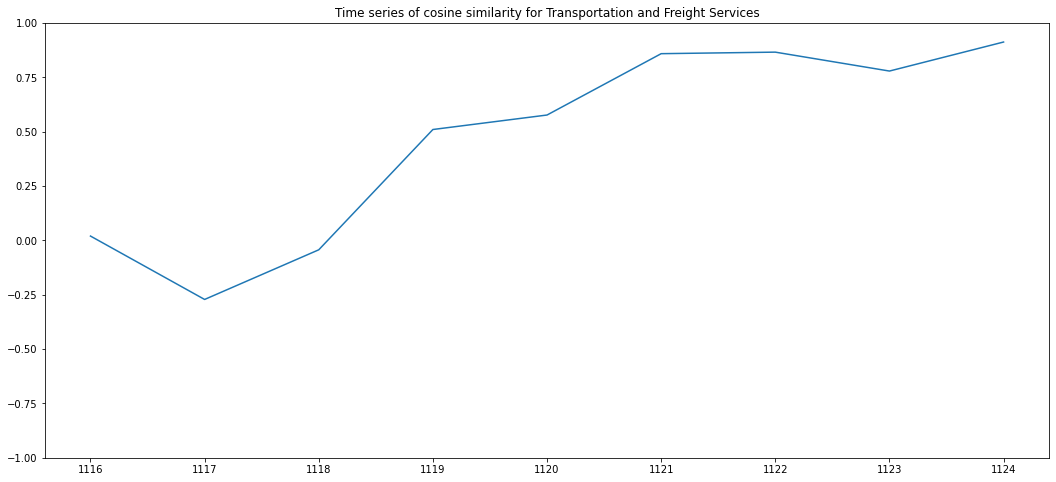

In [ ]:
plot_subject_timeseries(most_changed_field, embedding_type, year_intervals, f_code, num_dimensions, window_size, negative_sampling)
  

Plot time series for some FoRs:

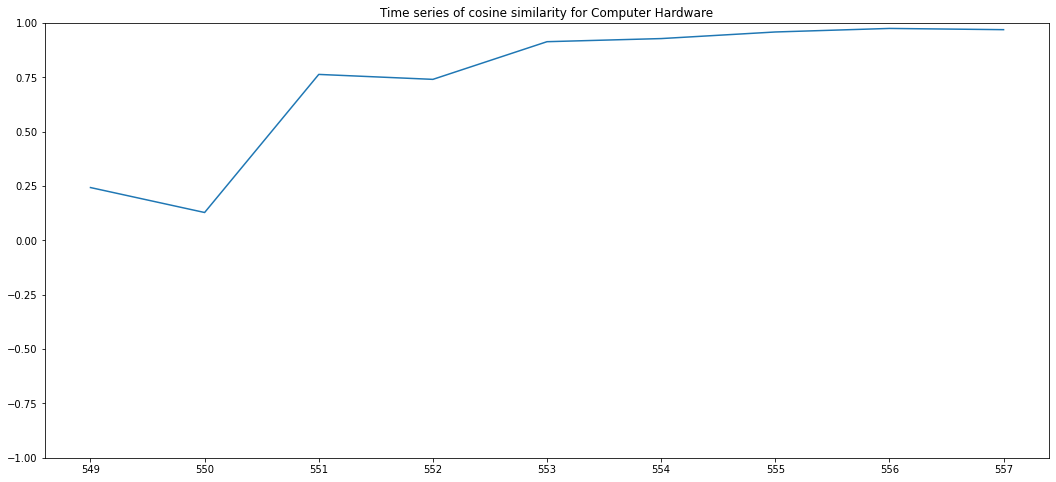

In [ ]:
if embedding_type == "cooccurrence":
  plot_subject_timeseries('Computer Hardware', embedding_type, year_intervals, f_code, num_dimensions, window_size, negative_sampling)
elif embedding_type == "aggregated":
  plot_subject_timeseries('Psychology', embedding_type, year_intervals, f_code, num_dimensions, "", "")

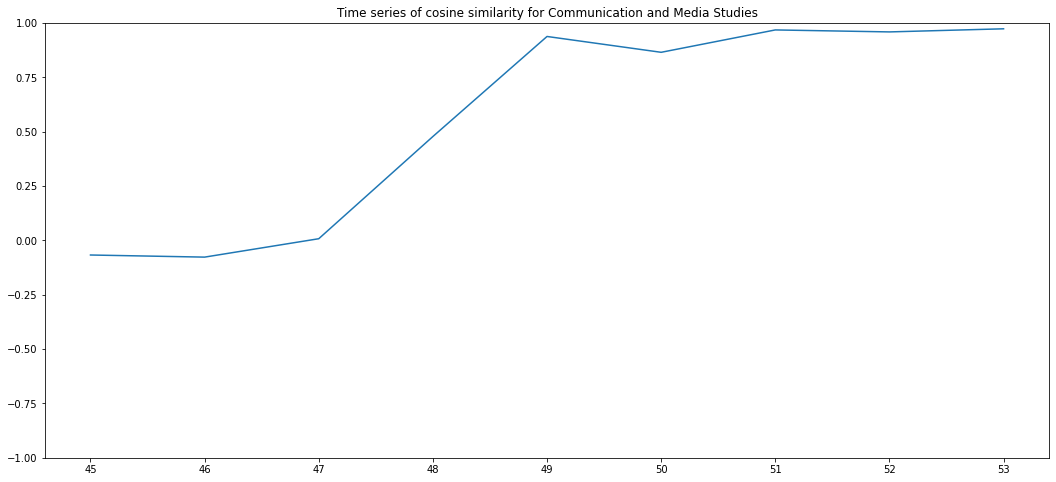

In [32]:
if embedding_type == "cooccurrence":
  plot_subject_timeseries('Communication and Media Studies', embedding_type, year_intervals, f_code, num_dimensions, window_size, negative_sampling)
elif embedding_type in ["aggregated", "journal"]:
  plot_subject_timeseries('Transportation and Freight Services', embedding_type, year_intervals, f_code, num_dimensions, "", "")

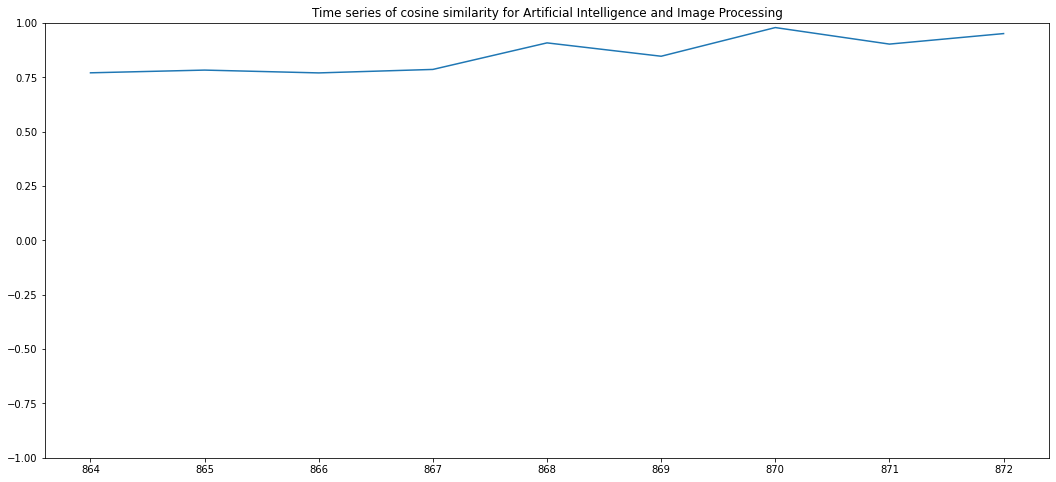

In [ ]:
if embedding_type == "cooccurrence":
  plot_subject_timeseries("Artificial Intelligence and Image Processing", embedding_type, year_intervals, f_code, num_dimensions, window_size, negative_sampling)
elif embedding_type in ["aggregated", "journal"]:
  plot_subject_timeseries("Artificial Intelligence and Image Processing", embedding_type, year_intervals, f_code, num_dimensions, "", "")

Plot time series for two disciplines (Communication and Media Studies and Computer Hardware):

In [44]:
field_cosine_df.loc[field_cosine_df['FoR'] == subject1]

,FoR,year,CosSimScoreWithRef,Neighbours
45,Communication and Media Studies,1990,-0.067355,"[[Film, Television and Digital Media, Journali..."
46,Communication and Media Studies,1993,-0.077079,"[[Film, Television and Digital Media, Journali..."
47,Communication and Media Studies,1996,0.007524,"[[Film, Television and Digital Media, Journali..."
48,Communication and Media Studies,1999,0.477577,"[[Film, Television and Digital Media, Journali..."
49,Communication and Media Studies,2002,0.937676,"[[Film, Television and Digital Media, Journali..."
50,Communication and Media Studies,2005,0.864873,"[[Film, Television and Digital Media, Journali..."
51,Communication and Media Studies,2008,0.967748,"[[Film, Television and Digital Media, Journali..."
52,Communication and Media Studies,2011,0.958654,"[[Film, Television and Digital Media, Journali..."
53,Communication and Media Studies,2014,0.972950,"[[Film, Television and Digital Media, Journali..."


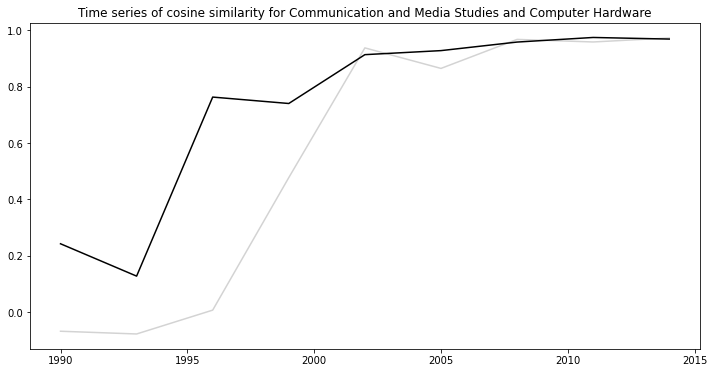

In [51]:
subject1 = "Communication and Media Studies"
subject2 = 'Computer Hardware'
from matplotlib.pyplot import figure
figure(figsize=(12,6))
plt.plot(field_cosine_df.loc[field_cosine_df['FoR'] == subject2,'year'],
          field_cosine_df.loc[field_cosine_df['FoR'] == subject1,'CosSimScoreWithRef'],
         color='lightgray')
plt.plot(field_cosine_df.loc[field_cosine_df['FoR'] == subject2,'year'],
         field_cosine_df.loc[field_cosine_df['FoR'] == subject2,'CosSimScoreWithRef'],
         color='black')
#field_cosine_df.loc[field_cosine_df['FoR'] == subject1,'CosSimScoreWithRef'].plot(x='year', ylim = [-1,1])
#field_cosine_df.loc[field_cosine_df['FoR'] == subject2,'CosSimScoreWithRef'].plot( x='year', ylim = [-1,1])
plt.title('Time series of cosine similarity for ' + subject1 + ' and ' + subject2)
plt
image_file_name = os.path.join(DIR_OUT2, 
                                  'Cosine_time_series_' + '2disciplines' + '_' + embedding_type + 
                                '_intervals-' + str(year_intervals) + 
                                '_level-' + str(f_code) +
                                '_dim-' + str(num_dimensions) + 
                                '_window-' + str(window_size) + 
                                '_negsampl-' + str(negative_sampling) + 
                                '.png')
plt.savefig(os.path.join(DIR_OUT2, image_file_name))

##### Visualize FoR profile change in time series



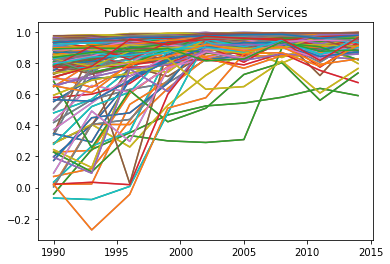

In [ ]:
if embedding_type == "cooccurrence":
    profile_change_image_file_name = os.path.join(DIR_OUT2,'FoR_profiles_cosine_time-series_' + embedding_type +  
                                '_intervals-' + str(year_intervals) + 
                                '_level-' + str(f_code) +
                                '_dim-' + str(num_dimensions) + 
                                '_window-' + str(window_size) + 
                                '_negsampl-' + str(negative_sampling) + '.png')
elif embedding_type in ["aggregated", "journal"]:
  profile_change_image_file_name = os.path.join(DIR_OUT2,'FoR_profiles_cosine_time-series_' + embedding_type + 
                                '_intervals-' + str(year_intervals) + 
                                '_level-' + str(f_code) +
                                '_dim-' + str(num_dimensions) + 
                                '.png')
# one plot:
for field in common_fields:
  #print(str(cosine_ref_year_next_years_field[field]))
  plt.plot(years, cosine_ref_year_next_years_field[field])
  plt.title('FoR profiles with reference to ' + str(reference_step) + ' time step')
  plt.savefig(profile_change_image_file_name)
  #files.download('samplefigure.png')
  #plt.show()
  
# one plot per FoR:
for field in common_fields:
  #print(str(cosine_ref_year_next_years_field[field]))
  plt.plot(years, cosine_ref_year_next_years_field[field])
  plt.title(field)
  #plt.show() # uncomment to show figures


A plot for hovering over


In [ ]:
px.line(field_cosine_df[field_cosine_df["FoR"].isin(fields_changing_list)], x = "year", y = "CosSimScoreWithRef", color = "FoR", hover_name = "FoR")

# Changepoint detection

Install Python package ruptures (https://github.com/deepcharles/ruptures)
Truong, L. Oudre, N. Vayatis. Selective review of offline change point detection methods. Signal Processing, 167:107299, 2020. 

In [ ]:
import sys
!{sys.executable} -m pip install ruptures

     |████████████████████████████████| 921kB 5.3MB/s 


Penalty: When the number of changes is unknown (P2), a constraint is added, in the form of a complexity penalty pen(·) (P2), to balance out the goodness-of-fit term V (T , y). The choice of the complexity penalty is related to the amplitude of the changes to detect: with too “small” a penalty (compared to the goodness-of-fit) in (P2), many change points are detected, even those that are the result of noise. Conversely, too much penalization only detects the most significant changes, or even none. (From https://arxiv.org/pdf/1801.00718.pdf)

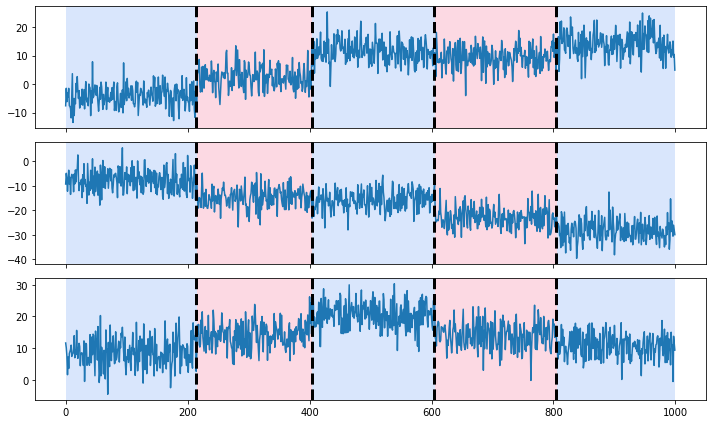

In [ ]:
import ruptures as rpt
# generate signal
n_samples, dim, sigma = 1000, 3, 4
n_bkps = 4  # number of breakpoints
signal, bkps = rpt.pw_constant(n_samples, dim, n_bkps, noise_std=sigma)

# detection
algo = rpt.Pelt(model="rbf").fit(signal)
result = algo.predict(pen=10)

# display
rpt.display(signal, bkps, result)
plt.show()

In [ ]:
signal[0]

In [ ]:
bkps

In [ ]:
result

In [ ]:
time = np.array([-6.09,5.68,8.42,-0.1,5,100,101,-2,50])
algo = rpt.Pelt(model="rbf", jump = 1).fit(time)
result = algo.predict(pen=0.5)
rpt.display(time, result)
plt.show()
print(str(result))

In [ ]:
result

Try on the cosine similarity time series

In [ ]:
common_fields = sorted(common_fields)

In [ ]:
common_fields[0]

In [ ]:
cosine_ref_year_next_years_field[common_fields[0]]

[0.9641022497301264,
 0.963024757492684,
 0.976599198044007,
 0.9782195221180437,
 0.9851750702279704,
 0.9878015820318072,
 0.9765956455322777,
 0.9732016303890035,
 0.9872440885104186]

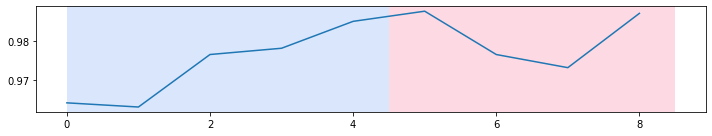

[5, 9]


In [ ]:
time_series = np.array(cosine_ref_year_next_years_field[common_fields[0]])
time_series
algo = rpt.Pelt(model="rbf").fit(time_series)
result = algo.predict(pen=0.1)
rpt.display(time_series, result)
plt.show()
print(str(result))

Changepoint detection for the most changed FoR:

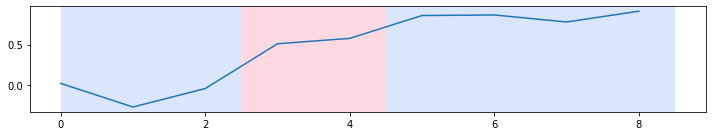

[3, 5, 9]


[1999, 2005]

In [ ]:
time_series = np.array(cosine_ref_year_next_years_field[most_changed_field])
#time_series
algo = rpt.Pelt(model="rbf", jump = 1).fit(time_series)
result = algo.predict(pen=0.1)
rpt.display(time_series, result)
plt.show()
print(str(result))
changepoints = list(set(result) - set([9])) # I exclude the past time point from the list of change points, because it is always a changepoint
change_years = list()
for cp in changepoints:
  year = first_year + 3*cp
  change_years.append(year)
change_years

In [ ]:
len(common_fields)

137

Accounting, Auditing and Accountability


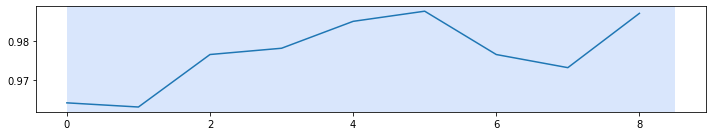

[9]
Aerospace Engineering


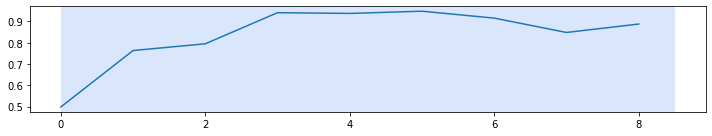

[9]
Agricultural Biotechnology


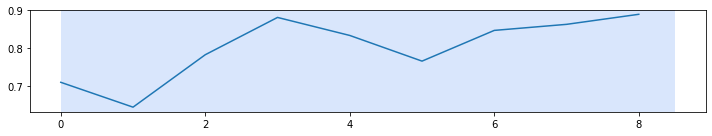

[9]
Agriculture, Land and Farm Management


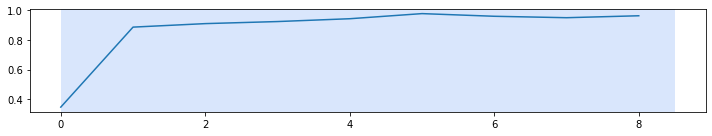

[9]
Analytical Chemistry


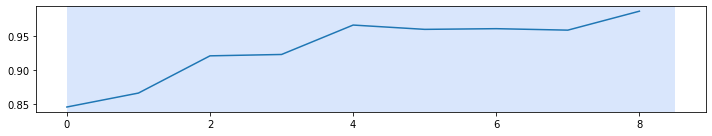

[9]
Animal Production


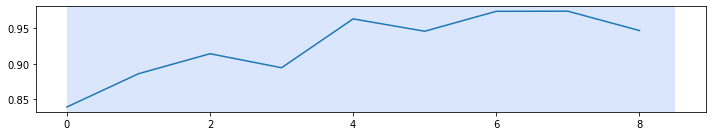

[9]
Anthropology


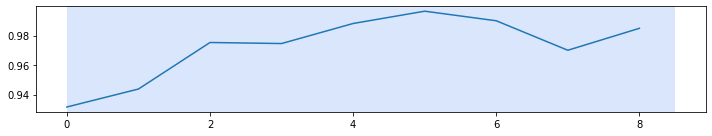

[9]
Applied Economics


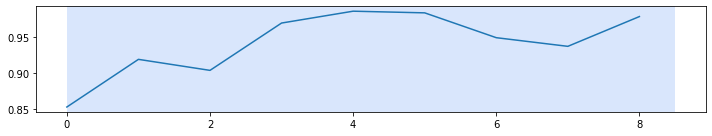

[9]
Applied Ethics


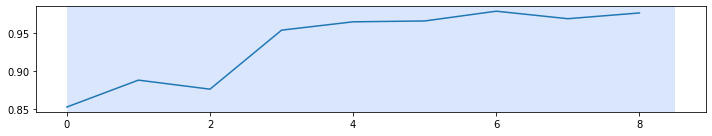

[9]
Applied Mathematics


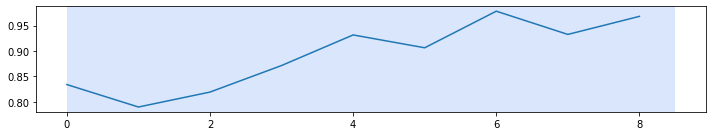

[9]
Archaeology


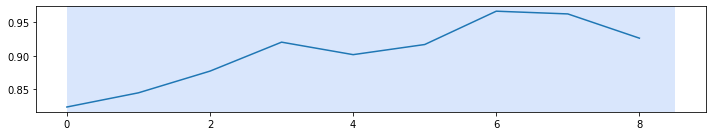

[9]
Architecture


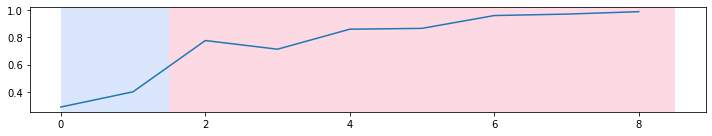

[2, 9]
Artificial Intelligence and Image Processing


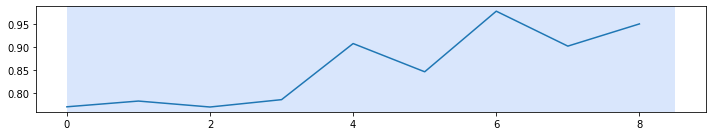

[9]
Astronomical and Space Sciences


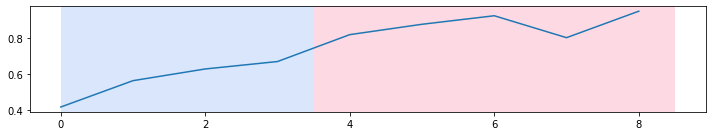

[4, 9]
Atmospheric Sciences


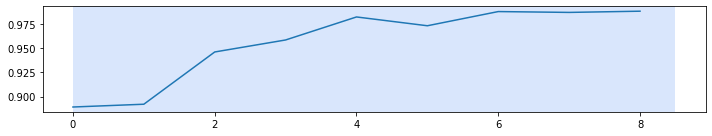

[9]
Atomic, Molecular, Nuclear, Particle and Plasma Physics


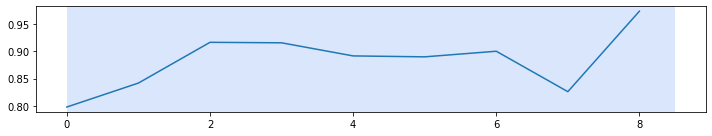

[9]
Automotive Engineering


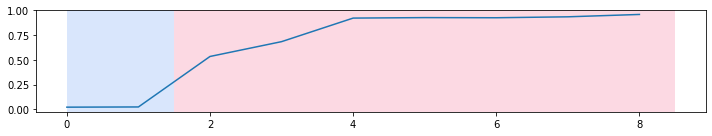

[2, 9]
Banking, Finance and Investment


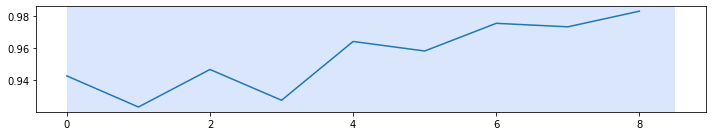

[9]
Biochemistry and Cell Biology


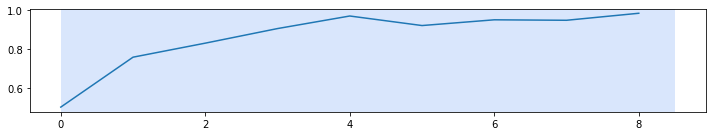

[9]
Biomedical Engineering


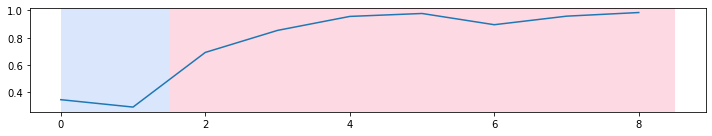

[2, 9]
Building


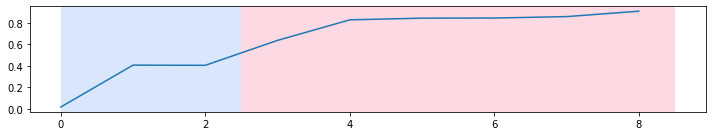

[3, 9]
Business and Management


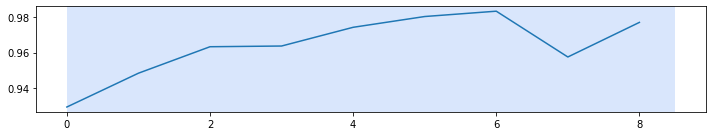

[9]
Cardiorespiratory Medicine and Haematology


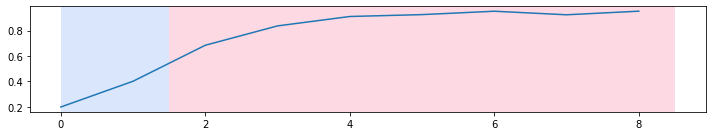

[2, 9]
Chemical Engineering


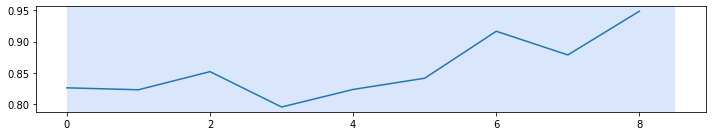

[9]
Civil Engineering


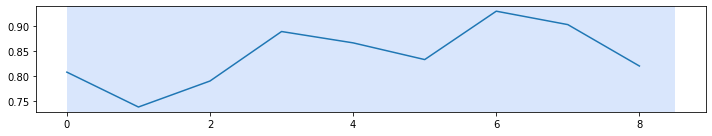

[9]
Classical Physics


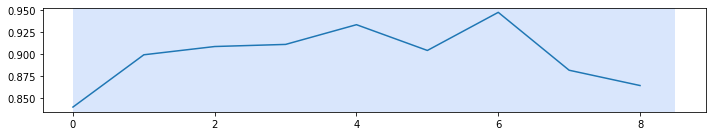

[9]
Clinical Sciences


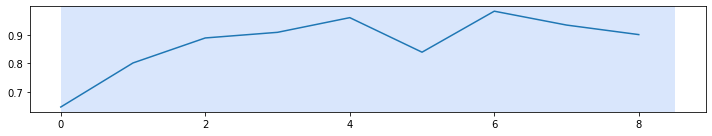

[9]
Cognitive Sciences


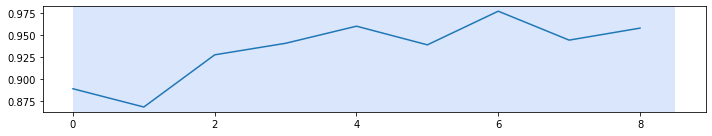

[9]
Communication and Media Studies


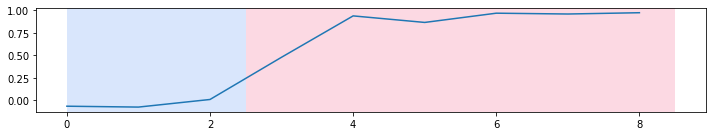

[3, 9]
Communications Technologies


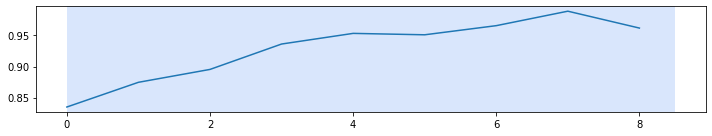

[9]
Complementary and Alternative Medicine


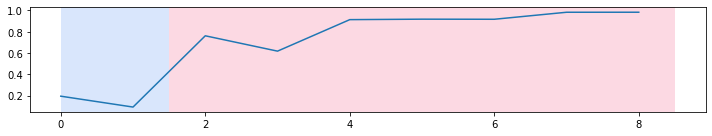

[2, 9]
Computation Theory and Mathematics


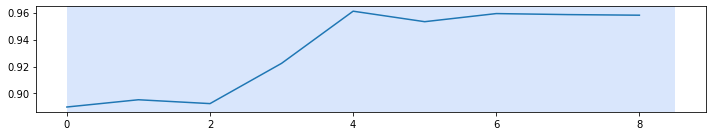

[9]
Computer Hardware


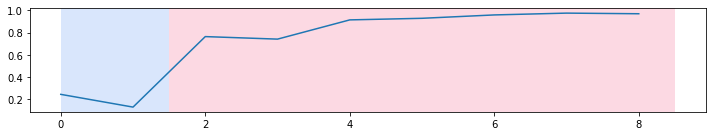

[2, 9]
Computer Software


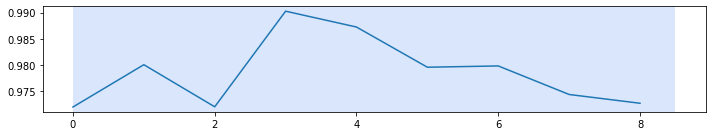

[9]
Condensed Matter Physics


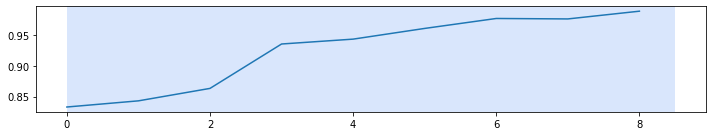

[9]
Criminology


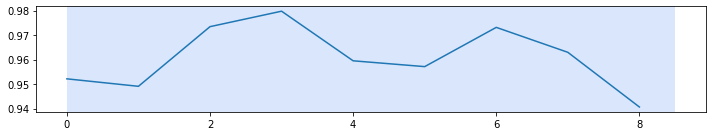

[9]
Crop and Pasture Production


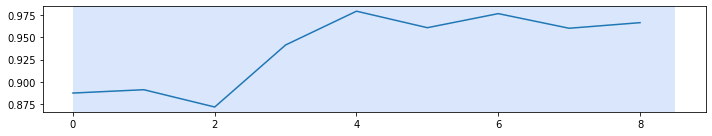

[9]
Cultural Studies


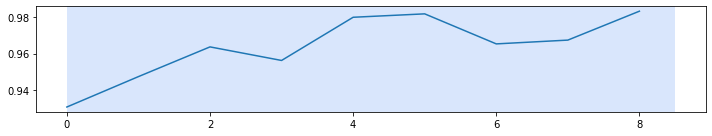

[9]
Curatorial and Related Studies


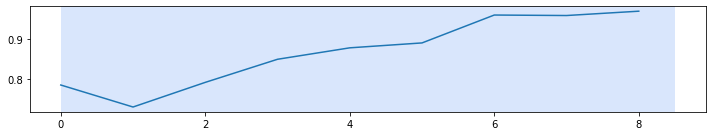

[9]
Curriculum and Pedagogy


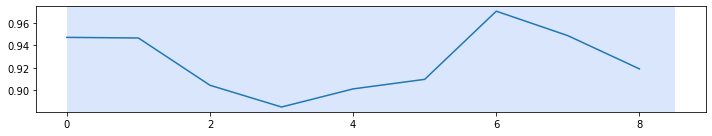

[9]
Data Format


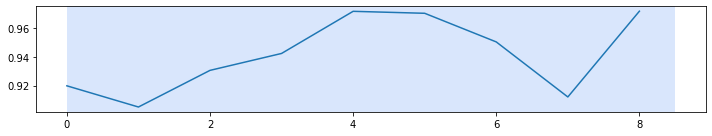

[9]
Demography


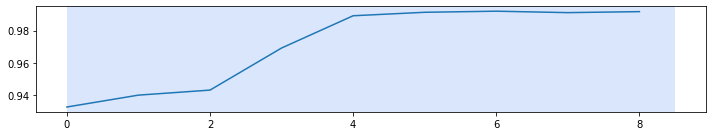

[9]
Dentistry


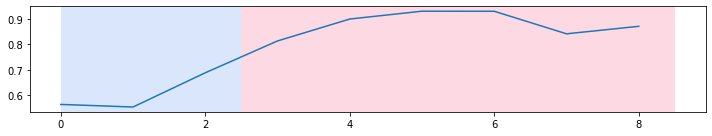

[3, 9]
Design Practice and Management


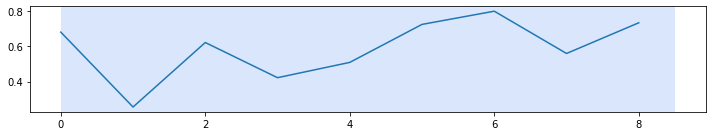

[9]
Distributed Computing


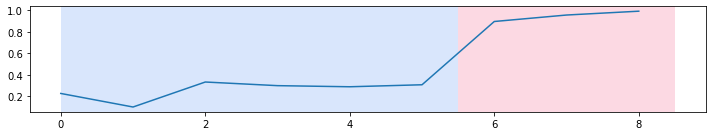

[6, 9]
Ecological Applications


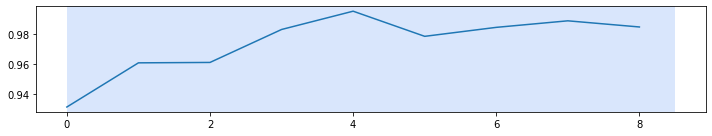

[9]
Ecology


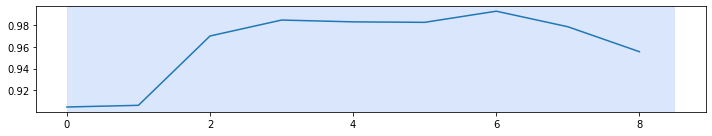

[9]
Econometrics


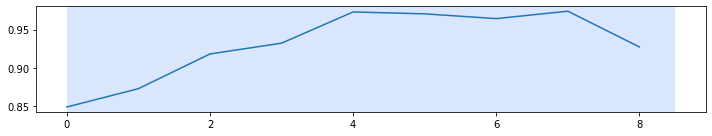

[9]
Economic Theory


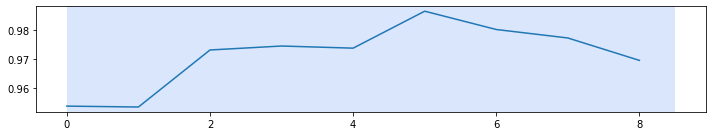

[9]
Education Systems


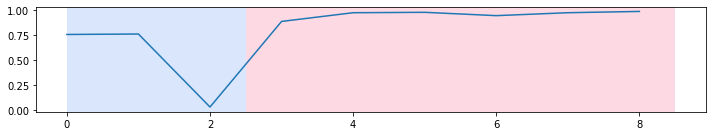

[3, 9]
Electrical and Electronic Engineering


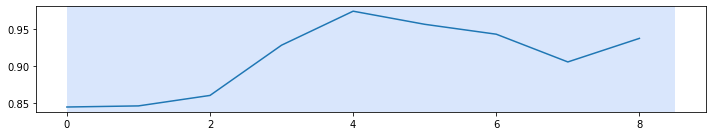

[9]
Environmental Engineering


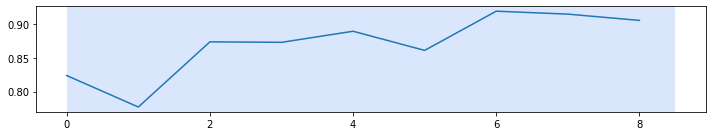

[9]
Environmental Science and Management


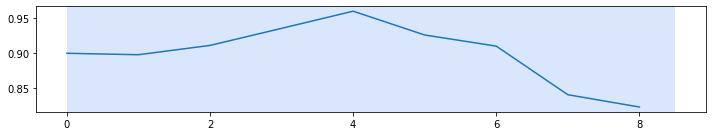

[9]
Evolutionary Biology


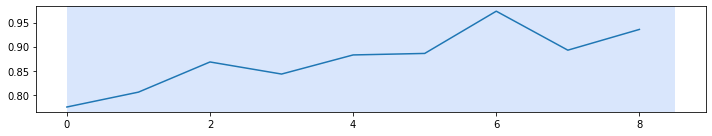

[9]
Film, Television and Digital Media


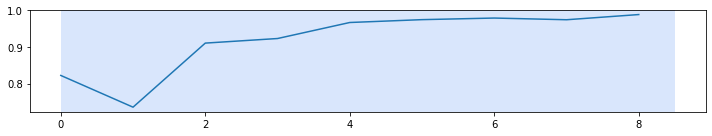

[9]
Fisheries Sciences


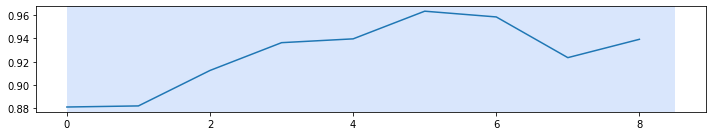

[9]
Food Sciences


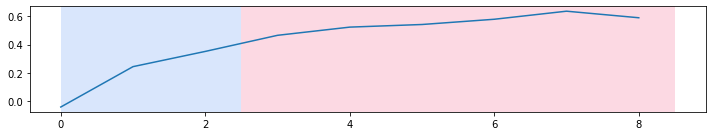

[3, 9]
Forestry Sciences


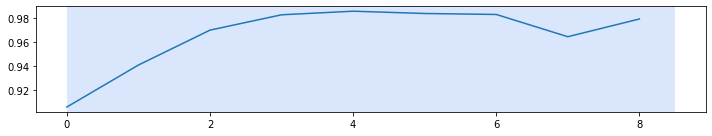

[9]
Genetics


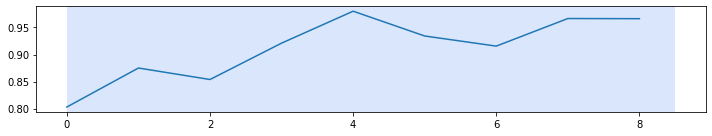

[9]
Geochemistry


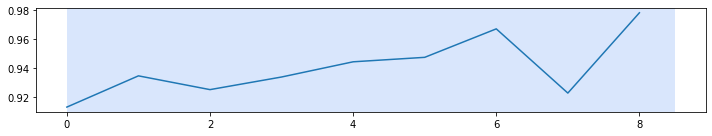

[9]
Geology


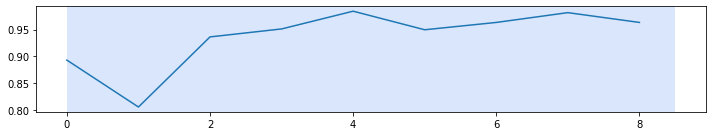

[9]
Geomatic Engineering


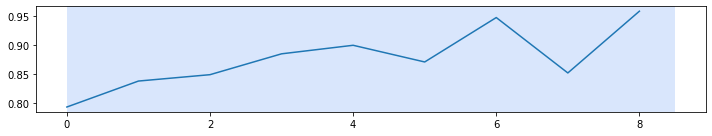

[9]
Geophysics


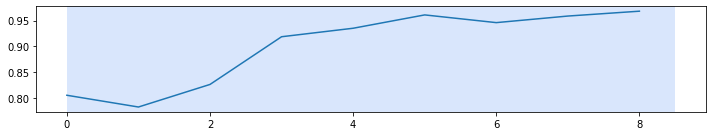

[9]
Historical Studies


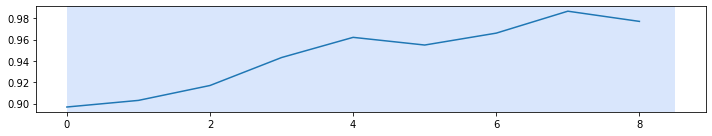

[9]
History and Philosophy of Specific Fields


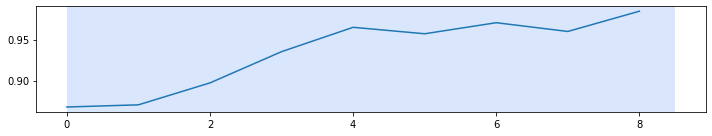

[9]
Horticultural Production


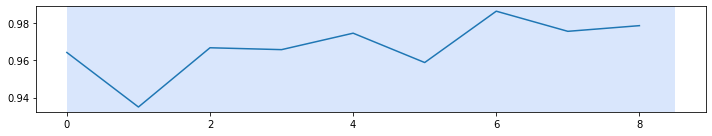

[9]
Human Geography


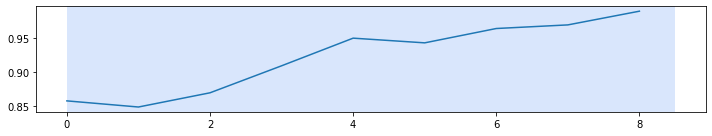

[9]
Human Movement and Sports Science


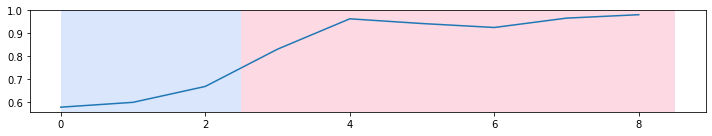

[3, 9]
Immunology


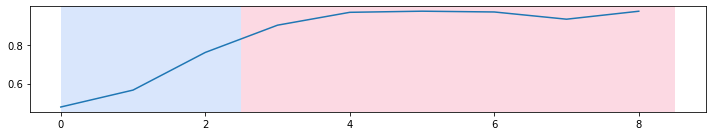

[3, 9]
Industrial Biotechnology


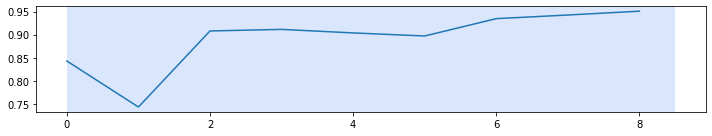

[9]
Information Systems


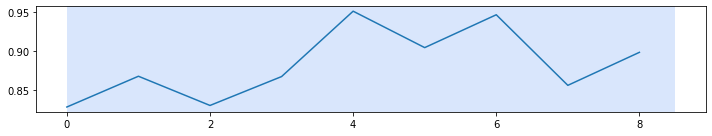

[9]
Inorganic Chemistry


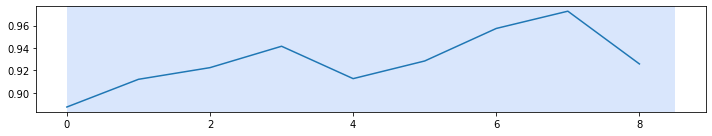

[9]
Interdisciplinary Engineering


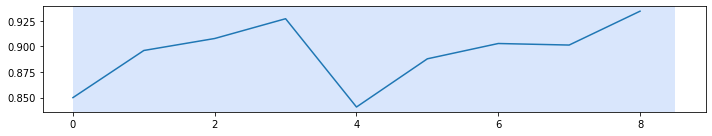

[9]
Journalism and Professional Writing


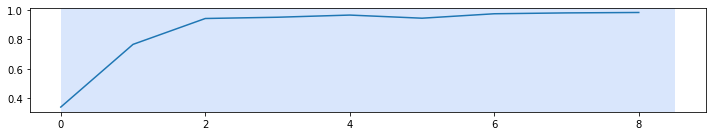

[9]
Language Studies


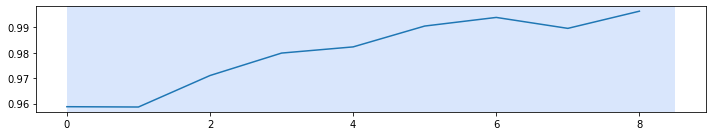

[9]
Law


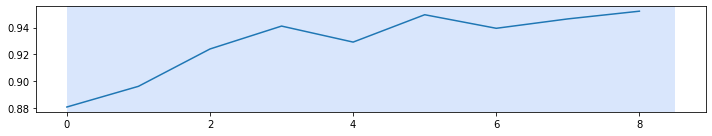

[9]
Linguistics


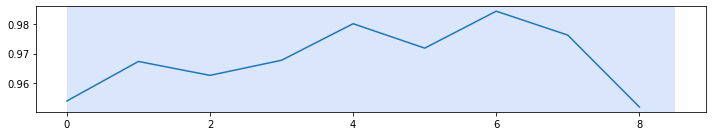

[9]
Literary Studies


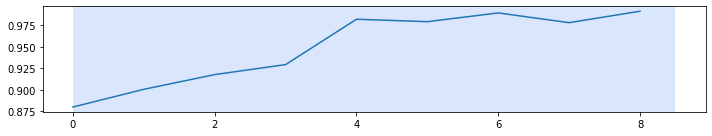

[9]
Macromolecular and Materials Chemistry


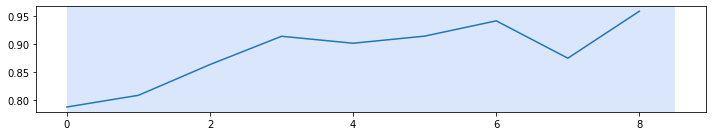

[9]
Manufacturing Engineering


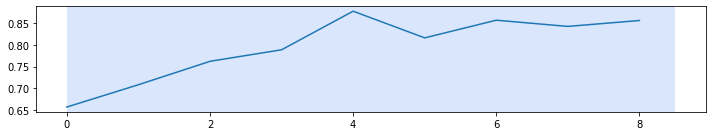

[9]
Maritime Engineering


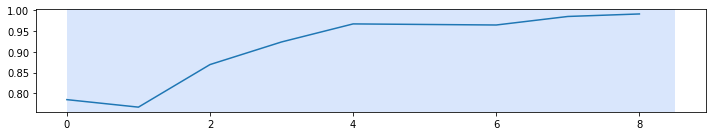

[9]
Marketing


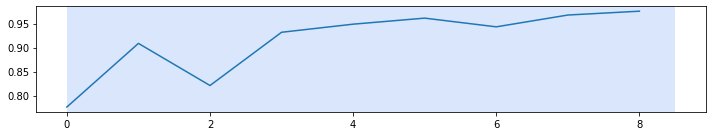

[9]
Materials Engineering


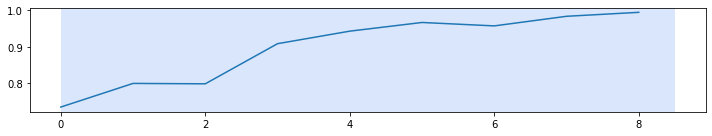

[9]
Mathematical Physics


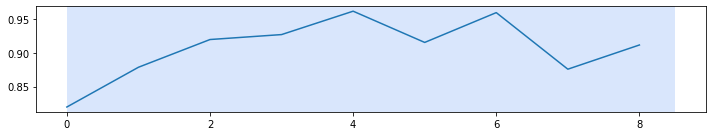

[9]
Mechanical Engineering


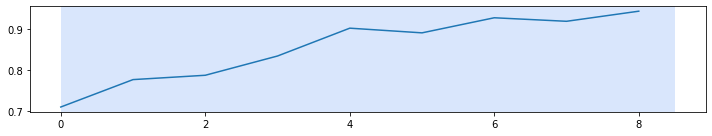

[9]
Medical Biochemistry and Metabolomics


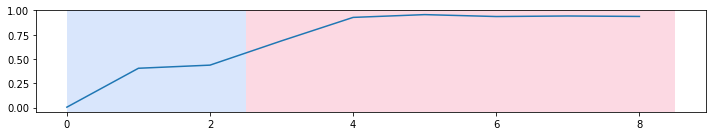

[3, 9]
Medical Biotechnology


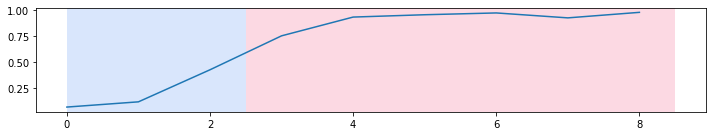

[3, 9]
Medical Microbiology


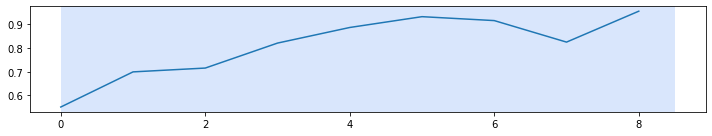

[9]
Medical Physiology


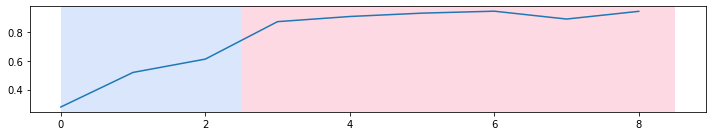

[3, 9]
Medicinal and Biomolecular Chemistry


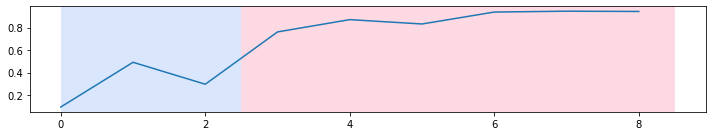

[3, 9]
Microbiology


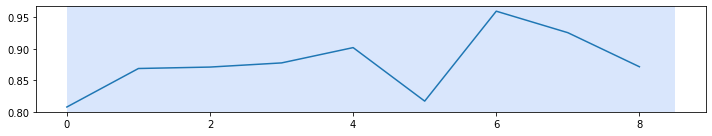

[9]
Nanotechnology


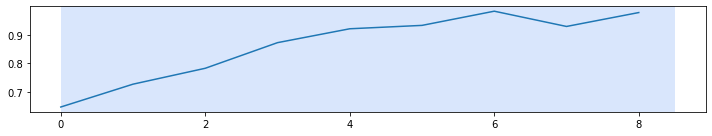

[9]
Neurosciences


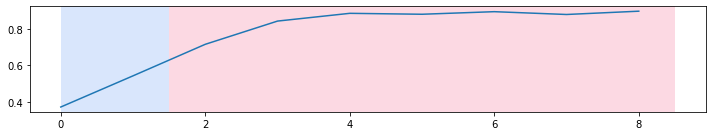

[2, 9]
Numerical and Computational Mathematics


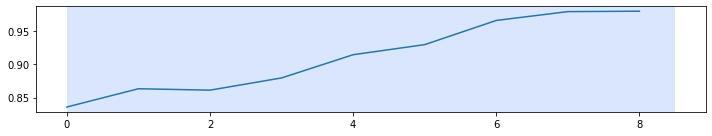

[9]
Nursing


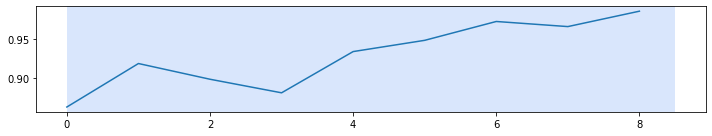

[9]
Nutrition and Dietetics


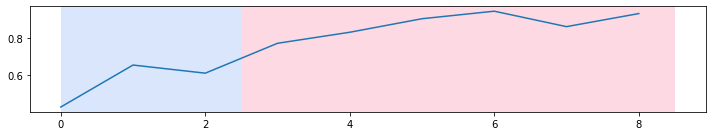

[3, 9]
Oceanography


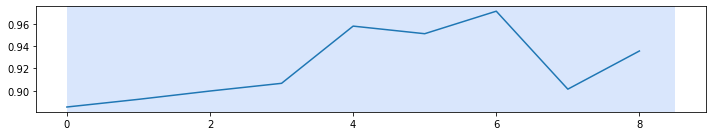

[9]
Oncology and Carcinogenesis


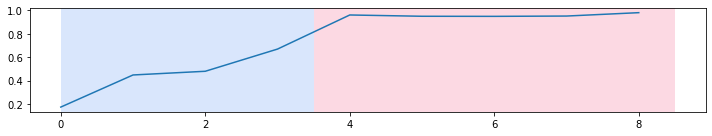

[4, 9]
Ophthalmology and Optometry


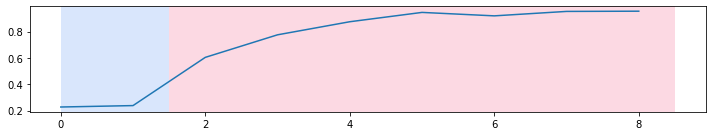

[2, 9]
Optical Physics


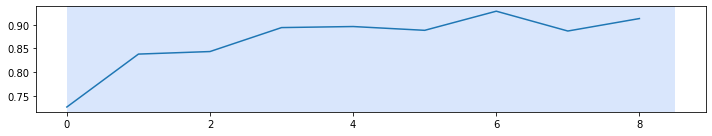

[9]
Organic Chemistry


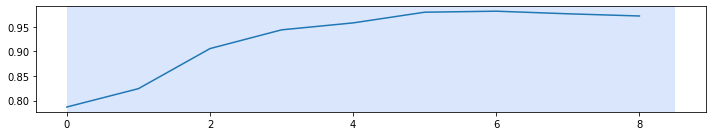

[9]
Other Agricultural and Veterinary Sciences


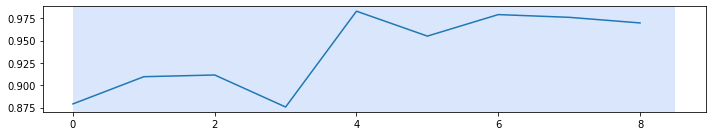

[9]
Other Biological Sciences


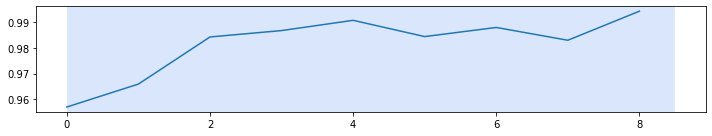

[9]
Other Chemical Sciences


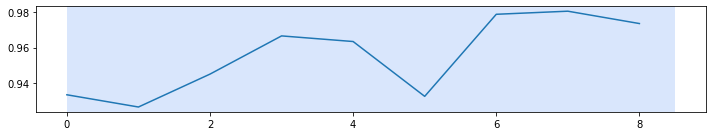

[9]
Other Law and Legal Studies


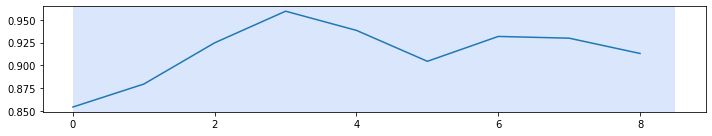

[9]
Other Medical and Health Sciences


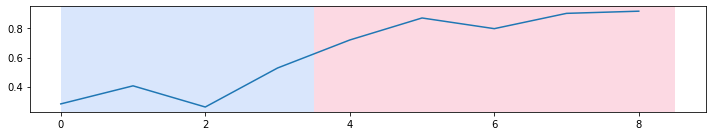

[4, 9]
Other Physical Sciences


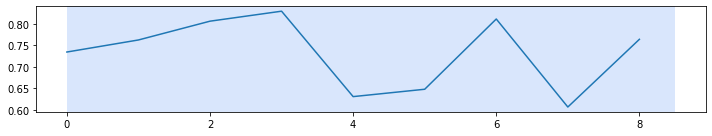

[9]
Other Psychology and Cognitive Sciences


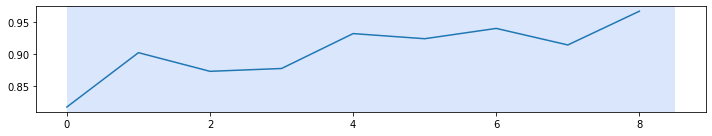

[9]
Other Studies In Human Society


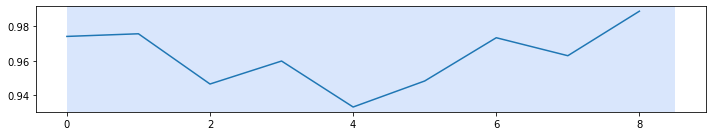

[9]
Paediatrics and Reproductive Medicine


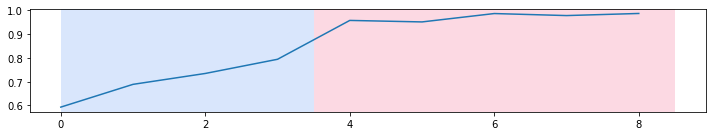

[4, 9]
Performing Arts and Creative Writing


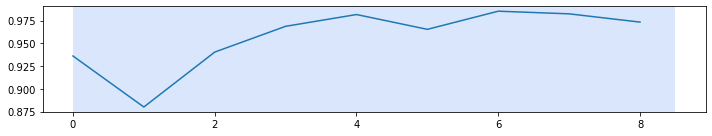

[9]
Pharmacology and Pharmaceutical Sciences


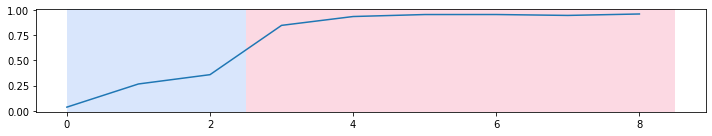

[3, 9]
Philosophy


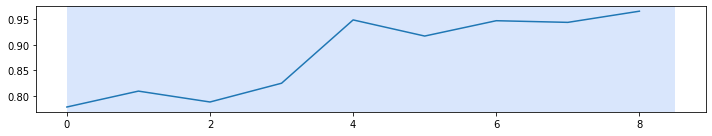

[9]
Physical Chemistry (incl. Structural)


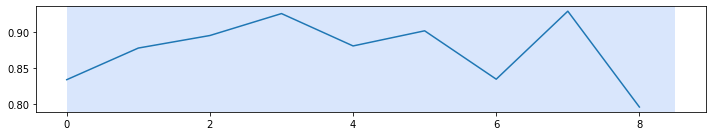

[9]
Physical Geography and Environmental Geoscience


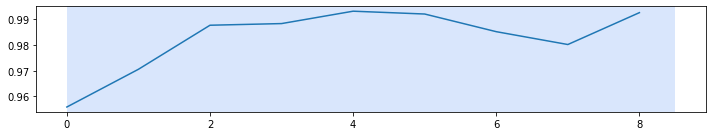

[9]
Physiology


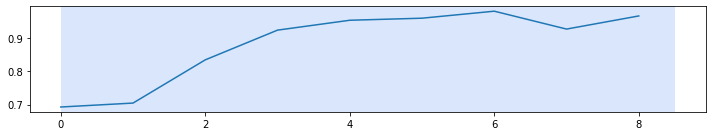

[9]
Plant Biology


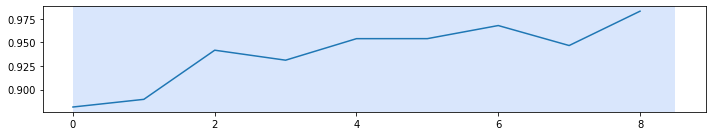

[9]
Policy and Administration


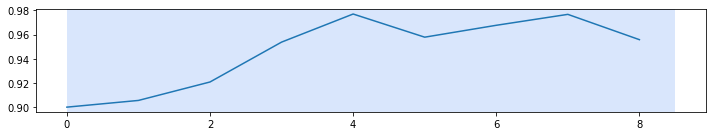

[9]
Political Science


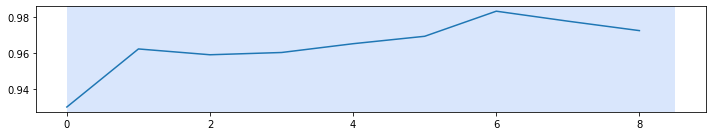

[9]
Psychology


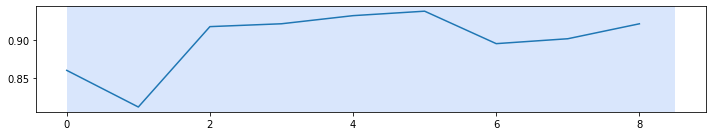

[9]
Public Health and Health Services


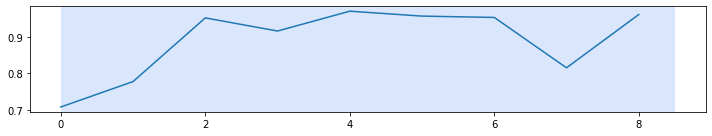

[9]
Pure Mathematics


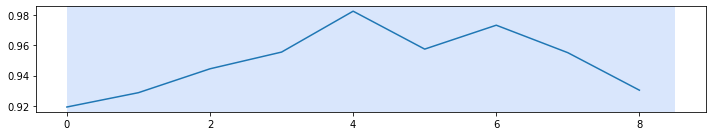

[9]
Quantum Physics


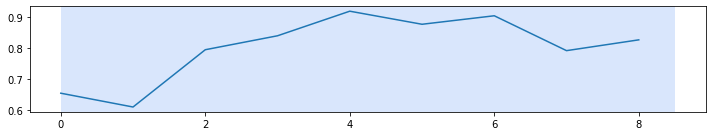

[9]
Religion and Religious Studies


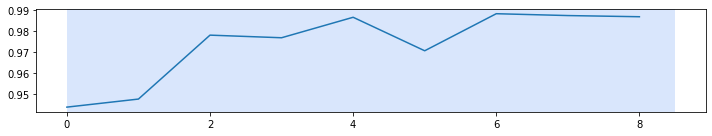

[9]
Resources Engineering and Extractive Metallurgy


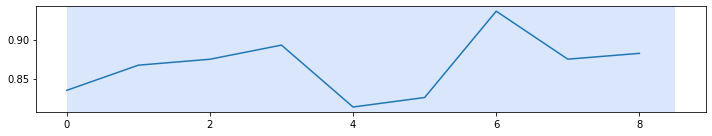

[9]
Social Work


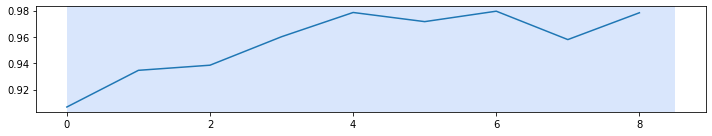

[9]
Sociology


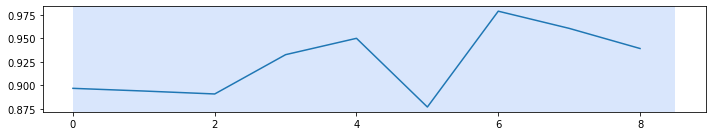

[9]
Soil Sciences


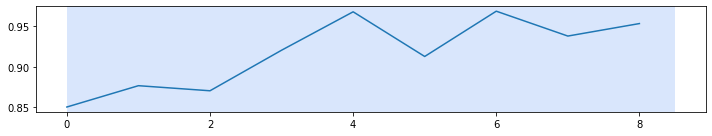

[9]
Specialist Studies In Education


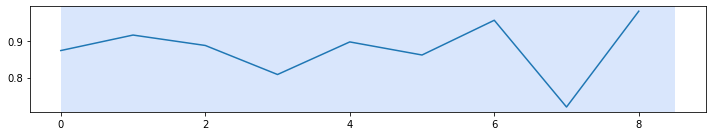

[9]
Statistics


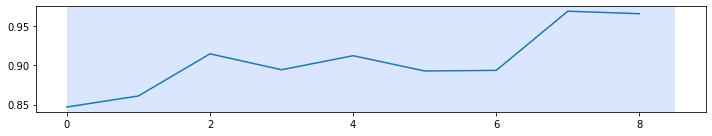

[9]
Theoretical and Computational Chemistry


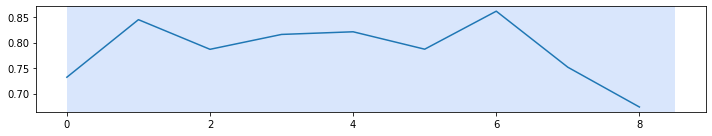

[9]
Tourism


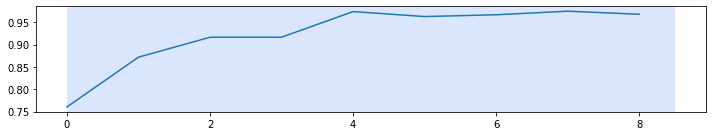

[9]
Transportation and Freight Services


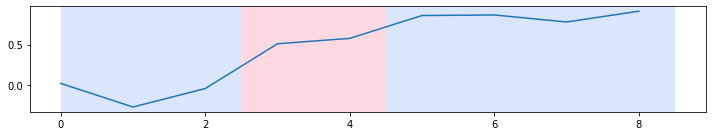

[3, 5, 9]
Urban and Regional Planning


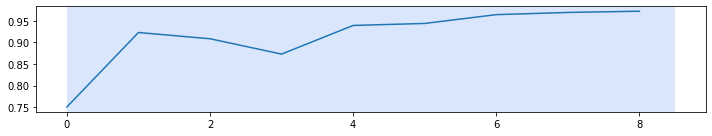

[9]
Veterinary Sciences


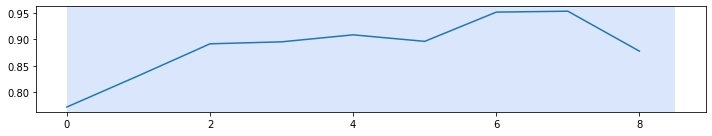

[9]
Visual Arts and Crafts


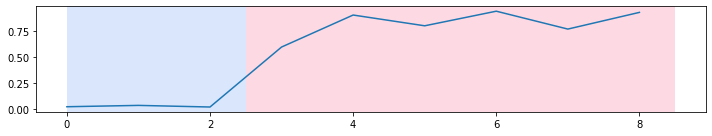

[3, 9]
Zoology


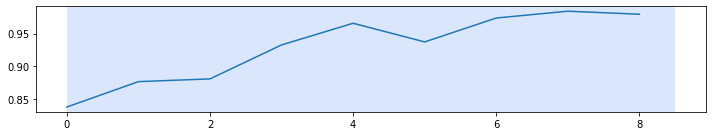

[9]


In [ ]:
changepoints_changedfields = dict() # maps a field which has at least one changepoint to its changepoint
for field in common_fields:
  print(field)
  #cosine_ref_year_next_years_field[field]
  time_series = np.array(cosine_ref_year_next_years_field[field])
  #print(str(time_series))
  # exact segmentation:
  model = "l1"  # "l1", "l2", "rbf"
  algo = rpt.Pelt(model=model, jump = 1).fit(time_series)
  # binary segmentation:
  #model = "ar"  # "l1", "l2", "rbf", "normal", "ar"
  #algo = rpt.Binseg(model=model).fit(time_series)
  # bottom-up segmentation:
  #model = "ar"  # "l2", "l1", "rbf", "linear", "normal", "ar"
  #algo = rpt.BottomUp(model=model).fit(time_series)
  # Window-based:
  #model = "l1"  # "l1", "l2", "rbf", "linear", "normal", "ar"
  #algo = rpt.Window(model=model, jump = 1).fit(time_series)
  #algo = rpt.BottomUp().fit(time_series)
  #algo = rpt.Binseg().fit(time_series)
  #algo = rpt.Window(width=4).fit(time_series)
  result = algo.predict(pen=0.5)
  rpt.display(time_series, result)
  plt.show()
  print(str(result))
  if len(result) > 1:
    changepoints = list(set(result) - set([9])) # I exclude the past time point from the list of change points, because it is always a changepoint
    change_years = list()
    for cp in changepoints:
      year = first_year + 3*cp
      change_years.append(year)
    changepoints_changedfields[field] = change_years

FoRs with at least one changepoint:

In [ ]:
changepoints_changedfields

{'Architecture': [1996],
 'Astronomical and Space Sciences': [2002],
 'Automotive Engineering': [1996],
 'Biomedical Engineering': [1996],
 'Building': [1999],
 'Cardiorespiratory Medicine and Haematology': [1996],
 'Communication and Media Studies': [1999],
 'Complementary and Alternative Medicine': [1996],
 'Computer Hardware': [1996],
 'Dentistry': [1999],
 'Distributed Computing': [2008],
 'Education Systems': [1999],
 'Food Sciences': [1999],
 'Human Movement and Sports Science': [1999],
 'Immunology': [1999],
 'Medical Biochemistry and Metabolomics': [1999],
 'Medical Biotechnology': [1999],
 'Medical Physiology': [1999],
 'Medicinal and Biomolecular Chemistry': [1999],
 'Neurosciences': [1996],
 'Nutrition and Dietetics': [1999],
 'Oncology and Carcinogenesis': [2002],
 'Ophthalmology and Optometry': [1996],
 'Other Medical and Health Sciences': [2002],
 'Paediatrics and Reproductive Medicine': [2002],
 'Pharmacology and Pharmaceutical Sciences': [1999],
 'Transportation and Fre

Print to output file

In [ ]:
if embedding_type == "cooccurrence":
    changepoints_file_name = os.path.join(DIR_OUT2,'FoR_changepoints_' + embedding_type +  
                                '_intervals-' + str(year_intervals) + 
                                '_level-' + str(f_code) +
                                '_dim-' + str(num_dimensions) + 
                                '_window-' + str(window_size) + 
                                '_negsampl-' + str(negative_sampling) + '.csv')
elif embedding_type in ["aggregated", "journal"]:
  changepoints_file_name = os.path.join(DIR_OUT2,'FoR_changepoints__' + embedding_type + 
                                '_intervals-' + str(year_intervals) + 
                                '_level-' + str(f_code) +
                                '_dim-' + str(num_dimensions) + 
                                '.csv')


Print changepoints to output file

In [ ]:
csv_columns = ['FoR','Changepoints']
csv_file = "Names.csv"
try:
    with open(changepoints_file_name, 'w') as csvfile:
        #writer = csv.DictWriter(csvfile, fieldnames=csv_columns)
        #writer = csv.DictWriter(csvfile, changepoints_changedfields.keys())
        #writer.writeheader()
        #writer.writerow(changepoints_changedfields)

        writer = csv.writer(csvfile)
        print(str(changepoints_changedfields.items()))
        writer.writerows(changepoints_changedfields.items())

except IOError:
    print("I/O error")

dict_items([('Architecture', [1996]), ('Astronomical and Space Sciences', [2002]), ('Automotive Engineering', [1996]), ('Biomedical Engineering', [1996]), ('Building', [1999]), ('Cardiorespiratory Medicine and Haematology', [1996]), ('Communication and Media Studies', [1999]), ('Complementary and Alternative Medicine', [1996]), ('Computer Hardware', [1996]), ('Dentistry', [1999]), ('Distributed Computing', [2008]), ('Education Systems', [1999]), ('Food Sciences', [1999]), ('Human Movement and Sports Science', [1999]), ('Immunology', [1999]), ('Medical Biochemistry and Metabolomics', [1999]), ('Medical Biotechnology', [1999]), ('Medical Physiology', [1999]), ('Medicinal and Biomolecular Chemistry', [1999]), ('Neurosciences', [1996]), ('Nutrition and Dietetics', [1999]), ('Oncology and Carcinogenesis', [2002]), ('Ophthalmology and Optometry', [1996]), ('Other Medical and Health Sciences', [2002]), ('Paediatrics and Reproductive Medicine', [2002]), ('Pharmacology and Pharmaceutical Scienc

Overlap between changed fields according to cosine and changed fields according to changepoint detection:

In [ ]:
list(set(list(fields_changing.index.values))&set(list(changepoints_changedfields.keys())))

['Visual Arts and Crafts',
 'Ophthalmology and Optometry',
 'Food Sciences',
 'Cardiorespiratory Medicine and Haematology',
 'Building',
 'Automotive Engineering',
 'Distributed Computing',
 'Architecture',
 'Biomedical Engineering',
 'Transportation and Freight Services',
 'Medical Biotechnology',
 'Complementary and Alternative Medicine',
 'Medicinal and Biomolecular Chemistry',
 'Neurosciences',
 'Education Systems',
 'Medical Biochemistry and Metabolomics',
 'Computer Hardware',
 'Medical Physiology',
 'Other Medical and Health Sciences',
 'Pharmacology and Pharmaceutical Sciences',
 'Oncology and Carcinogenesis',
 'Communication and Media Studies']

In [ ]:
len(list(set(list(fields_changing.index.values))&set(list(changepoints_changedfields.keys()))))

22

Output file name

In [ ]:
DIR_OUT = os.path.join(BASE_DIR, 'analysis', 'distance0.2')
if not os.path.exists(DIR_OUT):
    os.makedirs(DIR_OUT)
DIR_OUT2 = os.path.join(DIR_OUT,'profile change')
if not os.path.exists(DIR_OUT2):
    os.makedirs(DIR_OUT2)
if embedding_type == "cooccurrence":
  out_file_name = 'FoR-profiles_overlap-changed_between_'+str(first_y_emb) + '-' + str(last_y_emb) + '_Year_intervals-' + str(year_intervals) + '_num_dimensions-' + str(num_dimensions) + '_reference_step-' + str(reference_step) + '_window_size-' + str(window_size) + '_negative_sampling-' + str(negative_sampling) + '.csv'
elif embedding_type in ["aggregated", "journal"]:
  out_file_name = 'FoR-profiles_overlap-changed_between_'+str(first_y_emb) + '-' + str(last_y_emb) + '_Year_intervals-' + str(year_intervals) + '_num_dimensions-' + str(num_dimensions) + '_reference_step-' + str(reference_step) + '.csv'

Print overlapping list to file

In [ ]:
#out_file = open(os.path.join(DIR_OUT2, out_file_name), 'w')
for item in list(set(list(fields_changing.index.values))&set(list(changepoints_changedfields.keys()))):
  print(item)
  field_cosine_df2
  #out_file.write(item + "\t" + )
#out_file.close()


Visual Arts and Crafts
Ophthalmology and Optometry
Food Sciences
Cardiorespiratory Medicine and Haematology
Building
Automotive Engineering
Distributed Computing
Architecture
Biomedical Engineering
Transportation and Freight Services
Medical Biotechnology
Complementary and Alternative Medicine
Medicinal and Biomolecular Chemistry
Neurosciences
Education Systems
Medical Biochemistry and Metabolomics
Computer Hardware
Medical Physiology
Other Medical and Health Sciences
Pharmacology and Pharmaceutical Sciences
Oncology and Carcinogenesis
Communication and Media Studies
